In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import datanew as dt
import model_4_6 as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
# e/d + i + 6"

In [2]:
# print gpu
torch.cuda.set_device(1)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 1
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

cuda:1


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))

# for testing
transformed_dataset_raw = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),                                     
                                               dt.ToTensor()
                                           ]))

In [5]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

# for testing
dataloader_raw = DataLoader(transformed_dataset_raw, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


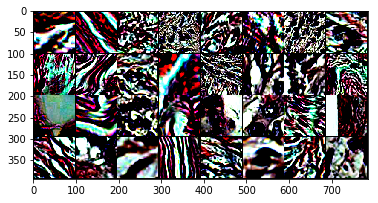

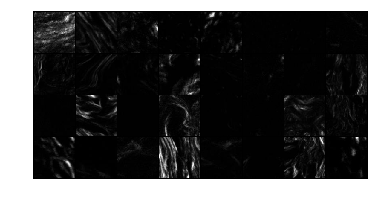

In [6]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


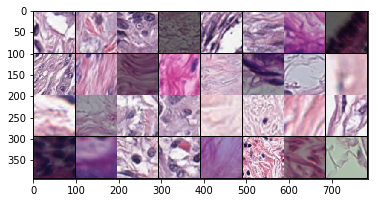

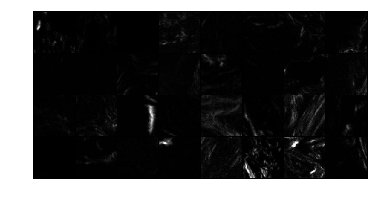

In [7]:
dt.show_patch(dataloader_raw) 

In [8]:
sample_test = dt.get_one_batch(dataloader_raw)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


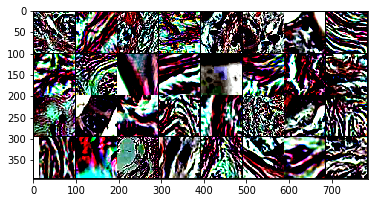

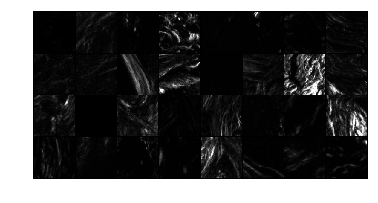

In [9]:
sample, meanHE, stdHE, meanSHG, stdSHG = dt.normalizebatch(sample_test)
# print(mean)
# print(std)

torch.Size([32, 1, 96, 96])


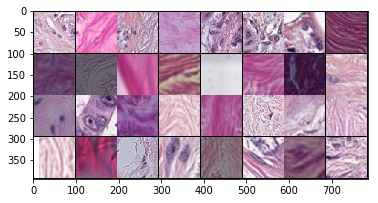

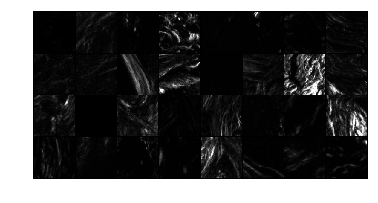

In [10]:
dt.show_one_batch(sample, meanHE, stdHE, meanSHG, stdSHG)

In [11]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [12]:
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = 1-ssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [13]:
l = 0.001
p = 0.75
windowsize = 4
for epoch in range(1, 20 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*0.5
        l = l*0.8
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.22357484698295593 lossSSIM: 0.9470802545547485
===> Epoch[1](0/25343): Loss: 0.4045
lossMSE: 0.22202177345752716 lossSSIM: 0.9433045983314514
===> Epoch[1](50/25343): Loss: 0.4023
lossMSE: 0.21875159442424774 lossSSIM: 0.9308682680130005
===> Epoch[1](100/25343): Loss: 0.3968
lossMSE: 0.2103227823972702 lossSSIM: 0.9298692941665649
===> Epoch[1](150/25343): Loss: 0.3902
lossMSE: 0.21528251469135284 lossSSIM: 0.9345547556877136
===> Epoch[1](200/25343): Loss: 0.3951
lossMSE: 0.21243926882743835 lossSSIM: 0.9337140321731567
===> Epoch[1](250/25343): Loss: 0.3928
lossMSE: 0.2198212593793869 lossSSIM: 0.9341153502464294
===> Epoch[1](300/25343): Loss: 0.3984
lossMSE: 0.2219582051038742 lossSSIM: 0.947662353515625
===> Epoch[1](350/25343): Loss: 0.4034
lossMSE: 0.2184131145477295 lossSSIM: 0.9435936808586121
===> Epoch[1](400/25343): Loss: 0.3997
lossMSE: 0.21355272829532623 lossSSIM: 0.9358194470405579
===> Epoch[1](450/25343): Loss: 0.3941
lossMSE: 0.21549473702907562 lossSSIM:

lossMSE: 0.14376068115234375 lossSSIM: 0.9254941940307617
===> Epoch[1](4250/25343): Loss: 0.3392
lossMSE: 0.14125460386276245 lossSSIM: 0.932722270488739
===> Epoch[1](4300/25343): Loss: 0.3391
lossMSE: 0.1356130689382553 lossSSIM: 0.9165828227996826
===> Epoch[1](4350/25343): Loss: 0.3309
lossMSE: 0.1445724368095398 lossSSIM: 0.9328281879425049
===> Epoch[1](4400/25343): Loss: 0.3416
lossMSE: 0.14147570729255676 lossSSIM: 0.9318492412567139
===> Epoch[1](4450/25343): Loss: 0.3391
lossMSE: 0.13810735940933228 lossSSIM: 0.926641047000885
===> Epoch[1](4500/25343): Loss: 0.3352
lossMSE: 0.13680532574653625 lossSSIM: 0.9195777773857117
===> Epoch[1](4550/25343): Loss: 0.3325
lossMSE: 0.13567055761814117 lossSSIM: 0.9320257306098938
===> Epoch[1](4600/25343): Loss: 0.3348
lossMSE: 0.13135617971420288 lossSSIM: 0.9284135699272156
===> Epoch[1](4650/25343): Loss: 0.3306
lossMSE: 0.13234016299247742 lossSSIM: 0.9183375835418701
===> Epoch[1](4700/25343): Loss: 0.3288
lossMSE: 0.1344044804573

lossMSE: 0.08690674602985382 lossSSIM: 0.9184767603874207
===> Epoch[1](8450/25343): Loss: 0.2948
lossMSE: 0.08393348753452301 lossSSIM: 0.906475305557251
===> Epoch[1](8500/25343): Loss: 0.2896
lossMSE: 0.08213722705841064 lossSSIM: 0.9057251811027527
===> Epoch[1](8550/25343): Loss: 0.2880
lossMSE: 0.08292320370674133 lossSSIM: 0.9081513285636902
===> Epoch[1](8600/25343): Loss: 0.2892
lossMSE: 0.0821952298283577 lossSSIM: 0.9085372090339661
===> Epoch[1](8650/25343): Loss: 0.2888
lossMSE: 0.08207327872514725 lossSSIM: 0.9069042205810547
===> Epoch[1](8700/25343): Loss: 0.2883
lossMSE: 0.07743404805660248 lossSSIM: 0.8914846777915955
===> Epoch[1](8750/25343): Loss: 0.2809
lossMSE: 0.08272269368171692 lossSSIM: 0.9219298958778381
===> Epoch[1](8800/25343): Loss: 0.2925
lossMSE: 0.07936170697212219 lossSSIM: 0.9075530767440796
===> Epoch[1](8850/25343): Loss: 0.2864
lossMSE: 0.08019406348466873 lossSSIM: 0.9126874208450317
===> Epoch[1](8900/25343): Loss: 0.2883
lossMSE: 0.07689884305

lossMSE: 0.04846926033496857 lossSSIM: 0.8934133052825928
===> Epoch[1](12650/25343): Loss: 0.2597
lossMSE: 0.049400050193071365 lossSSIM: 0.8846721053123474
===> Epoch[1](12700/25343): Loss: 0.2582
lossMSE: 0.04792649298906326 lossSSIM: 0.8947932720184326
===> Epoch[1](12750/25343): Loss: 0.2596
lossMSE: 0.04939796403050423 lossSSIM: 0.8967127799987793
===> Epoch[1](12800/25343): Loss: 0.2612
lossMSE: 0.047820236533880234 lossSSIM: 0.8998057246208191
===> Epoch[1](12850/25343): Loss: 0.2608
lossMSE: 0.04572292044758797 lossSSIM: 0.8835009932518005
===> Epoch[1](12900/25343): Loss: 0.2552
lossMSE: 0.05001000314950943 lossSSIM: 0.8952353596687317
===> Epoch[1](12950/25343): Loss: 0.2613
lossMSE: 0.048178885132074356 lossSSIM: 0.9175319671630859
===> Epoch[1](13000/25343): Loss: 0.2655
lossMSE: 0.045935552567243576 lossSSIM: 0.8925362229347229
===> Epoch[1](13050/25343): Loss: 0.2576
lossMSE: 0.046022482216358185 lossSSIM: 0.8659085035324097
===> Epoch[1](13100/25343): Loss: 0.2510
lossM

lossMSE: 0.02849334478378296 lossSSIM: 0.8521864414215088
===> Epoch[1](16800/25343): Loss: 0.2344
lossMSE: 0.02789338491857052 lossSSIM: 0.84808349609375
===> Epoch[1](16850/25343): Loss: 0.2329
lossMSE: 0.025614267215132713 lossSSIM: 0.854016125202179
===> Epoch[1](16900/25343): Loss: 0.2327
lossMSE: 0.02683882974088192 lossSSIM: 0.8619460463523865
===> Epoch[1](16950/25343): Loss: 0.2356
lossMSE: 0.02483553998172283 lossSSIM: 0.8126366138458252
===> Epoch[1](17000/25343): Loss: 0.2218
lossMSE: 0.028766505420207977 lossSSIM: 0.8676284551620483
===> Epoch[1](17050/25343): Loss: 0.2385
lossMSE: 0.031093282625079155 lossSSIM: 0.8513943552970886
===> Epoch[1](17100/25343): Loss: 0.2362
lossMSE: 0.02819792740046978 lossSSIM: 0.8473256826400757
===> Epoch[1](17150/25343): Loss: 0.2330
lossMSE: 0.025167711079120636 lossSSIM: 0.8430339097976685
===> Epoch[1](17200/25343): Loss: 0.2296
lossMSE: 0.024311184883117676 lossSSIM: 0.8310631513595581
===> Epoch[1](17250/25343): Loss: 0.2260
lossMSE:

lossMSE: 0.01798270270228386 lossSSIM: 0.7718361616134644
===> Epoch[1](20950/25343): Loss: 0.2064
lossMSE: 0.01759549044072628 lossSSIM: 0.7782612442970276
===> Epoch[1](21000/25343): Loss: 0.2078
lossMSE: 0.017578106373548508 lossSSIM: 0.7994483709335327
===> Epoch[1](21050/25343): Loss: 0.2130
lossMSE: 0.019564185291528702 lossSSIM: 0.8045190572738647
===> Epoch[1](21100/25343): Loss: 0.2158
lossMSE: 0.019647665321826935 lossSSIM: 0.8247498869895935
===> Epoch[1](21150/25343): Loss: 0.2209
lossMSE: 0.01642300747334957 lossSSIM: 0.8051108121871948
===> Epoch[1](21200/25343): Loss: 0.2136
lossMSE: 0.01621813327074051 lossSSIM: 0.8000280857086182
===> Epoch[1](21250/25343): Loss: 0.2122
lossMSE: 0.02027440071105957 lossSSIM: 0.7998932003974915
===> Epoch[1](21300/25343): Loss: 0.2152
lossMSE: 0.020192256197333336 lossSSIM: 0.7831346988677979
===> Epoch[1](21350/25343): Loss: 0.2109
lossMSE: 0.019701950252056122 lossSSIM: 0.7934118509292603
===> Epoch[1](21400/25343): Loss: 0.2131
lossM

lossMSE: 0.017283091321587563 lossSSIM: 0.6804438829421997
===> Epoch[1](25100/25343): Loss: 0.1831
lossMSE: 0.013093903660774231 lossSSIM: 0.7026312351226807
===> Epoch[1](25150/25343): Loss: 0.1855
lossMSE: 0.012624595314264297 lossSSIM: 0.6781502366065979
===> Epoch[1](25200/25343): Loss: 0.1790
lossMSE: 0.012492761015892029 lossSSIM: 0.7089347839355469
===> Epoch[1](25250/25343): Loss: 0.1866
lossMSE: 0.013512032106518745 lossSSIM: 0.7091141939163208
===> Epoch[1](25300/25343): Loss: 0.1874
===> Epoch 1 Complete: Avg. Loss: 0.2704
lossMSE: 0.014076722785830498 lossSSIM: 0.6924947500228882
===> Epoch[2](0/25343): Loss: 0.1837
lossMSE: 0.012841517105698586 lossSSIM: 0.7077566385269165
===> Epoch[2](50/25343): Loss: 0.1866
lossMSE: 0.014863143675029278 lossSSIM: 0.6601206064224243
===> Epoch[2](100/25343): Loss: 0.1762
lossMSE: 0.012682787142693996 lossSSIM: 0.6739407181739807
===> Epoch[2](150/25343): Loss: 0.1780
lossMSE: 0.012674925848841667 lossSSIM: 0.6702244877815247
===> Epoch[

lossMSE: 0.013027934357523918 lossSSIM: 0.585971474647522
===> Epoch[2](3900/25343): Loss: 0.1563
lossMSE: 0.011905806139111519 lossSSIM: 0.5823441743850708
===> Epoch[2](3950/25343): Loss: 0.1545
lossMSE: 0.011650054715573788 lossSSIM: 0.5856693983078003
===> Epoch[2](4000/25343): Loss: 0.1552
lossMSE: 0.010978864505887032 lossSSIM: 0.6024224162101746
===> Epoch[2](4050/25343): Loss: 0.1588
lossMSE: 0.010702574625611305 lossSSIM: 0.5821183919906616
===> Epoch[2](4100/25343): Loss: 0.1536
lossMSE: 0.009323332458734512 lossSSIM: 0.5665349364280701
===> Epoch[2](4150/25343): Loss: 0.1486
lossMSE: 0.011152702383697033 lossSSIM: 0.5794919729232788
===> Epoch[2](4200/25343): Loss: 0.1532
lossMSE: 0.01043066754937172 lossSSIM: 0.5307666063308716
===> Epoch[2](4250/25343): Loss: 0.1405
lossMSE: 0.016416022554039955 lossSSIM: 0.5366249084472656
===> Epoch[2](4300/25343): Loss: 0.1465
lossMSE: 0.011275569908320904 lossSSIM: 0.5722944140434265
===> Epoch[2](4350/25343): Loss: 0.1515
lossMSE: 0.0

lossMSE: 0.011802143417298794 lossSSIM: 0.4967643618583679
===> Epoch[2](8050/25343): Loss: 0.1330
lossMSE: 0.011396575719118118 lossSSIM: 0.4969201683998108
===> Epoch[2](8100/25343): Loss: 0.1328
lossMSE: 0.012202280573546886 lossSSIM: 0.4477307200431824
===> Epoch[2](8150/25343): Loss: 0.1211
lossMSE: 0.010240714065730572 lossSSIM: 0.46885186433792114
===> Epoch[2](8200/25343): Loss: 0.1249
lossMSE: 0.010834526270627975 lossSSIM: 0.46192651987075806
===> Epoch[2](8250/25343): Loss: 0.1236
lossMSE: 0.011253267526626587 lossSSIM: 0.4778180718421936
===> Epoch[2](8300/25343): Loss: 0.1279
lossMSE: 0.009834039956331253 lossSSIM: 0.4602001905441284
===> Epoch[2](8350/25343): Loss: 0.1224
lossMSE: 0.014802336692810059 lossSSIM: 0.46316051483154297
===> Epoch[2](8400/25343): Loss: 0.1269
lossMSE: 0.01149680744856596 lossSSIM: 0.4707046151161194
===> Epoch[2](8450/25343): Loss: 0.1263
lossMSE: 0.007987876422703266 lossSSIM: 0.41847556829452515
===> Epoch[2](8500/25343): Loss: 0.1106
lossMSE

lossMSE: 0.011510001495480537 lossSSIM: 0.3865818977355957
===> Epoch[2](12200/25343): Loss: 0.1053
lossMSE: 0.00780057068914175 lossSSIM: 0.3805316090583801
===> Epoch[2](12250/25343): Loss: 0.1010
lossMSE: 0.008203377015888691 lossSSIM: 0.39855849742889404
===> Epoch[2](12300/25343): Loss: 0.1058
lossMSE: 0.007035842165350914 lossSSIM: 0.4030373692512512
===> Epoch[2](12350/25343): Loss: 0.1060
lossMSE: 0.00881829671561718 lossSSIM: 0.4093630909919739
===> Epoch[2](12400/25343): Loss: 0.1090
lossMSE: 0.008364253677427769 lossSSIM: 0.4006996750831604
===> Epoch[2](12450/25343): Loss: 0.1064
lossMSE: 0.006486392579972744 lossSSIM: 0.3603653311729431
===> Epoch[2](12500/25343): Loss: 0.0950
lossMSE: 0.008661055006086826 lossSSIM: 0.4099327325820923
===> Epoch[2](12550/25343): Loss: 0.1090
lossMSE: 0.006858077831566334 lossSSIM: 0.34877169132232666
===> Epoch[2](12600/25343): Loss: 0.0923
lossMSE: 0.006628050003200769 lossSSIM: 0.3808562159538269
===> Epoch[2](12650/25343): Loss: 0.1002


lossMSE: 0.0050302911549806595 lossSSIM: 0.33575254678726196
===> Epoch[2](16300/25343): Loss: 0.0877
lossMSE: 0.003628999460488558 lossSSIM: 0.30498558282852173
===> Epoch[2](16350/25343): Loss: 0.0790
lossMSE: 0.005502029787749052 lossSSIM: 0.3092811703681946
===> Epoch[2](16400/25343): Loss: 0.0814
lossMSE: 0.00987365934997797 lossSSIM: 0.31844305992126465
===> Epoch[2](16450/25343): Loss: 0.0870
lossMSE: 0.004419385921210051 lossSSIM: 0.31472980976104736
===> Epoch[2](16500/25343): Loss: 0.0820
lossMSE: 0.006905379705131054 lossSSIM: 0.32435548305511475
===> Epoch[2](16550/25343): Loss: 0.0863
lossMSE: 0.01559645589441061 lossSSIM: 0.33750563859939575
===> Epoch[2](16600/25343): Loss: 0.0961
lossMSE: 0.004485273268073797 lossSSIM: 0.3025829792022705
===> Epoch[2](16650/25343): Loss: 0.0790
lossMSE: 0.0049822633154690266 lossSSIM: 0.3156145215034485
===> Epoch[2](16700/25343): Loss: 0.0826
lossMSE: 0.019806375727057457 lossSSIM: 0.3200845718383789
===> Epoch[2](16750/25343): Loss: 0

lossMSE: 0.0026321278419345617 lossSSIM: 0.2575880289077759
===> Epoch[2](20400/25343): Loss: 0.0664
lossMSE: 0.005481221247464418 lossSSIM: 0.3089343309402466
===> Epoch[2](20450/25343): Loss: 0.0813
lossMSE: 0.0024730837903916836 lossSSIM: 0.2534477710723877
===> Epoch[2](20500/25343): Loss: 0.0652
lossMSE: 0.006009941920638084 lossSSIM: 0.27555376291275024
===> Epoch[2](20550/25343): Loss: 0.0734
lossMSE: 0.006207963451743126 lossSSIM: 0.2829369306564331
===> Epoch[2](20600/25343): Loss: 0.0754
lossMSE: 0.004909659270197153 lossSSIM: 0.3105180859565735
===> Epoch[2](20650/25343): Loss: 0.0813
lossMSE: 0.012957477942109108 lossSSIM: 0.2914733290672302
===> Epoch[2](20700/25343): Loss: 0.0826
lossMSE: 0.0027839881367981434 lossSSIM: 0.23935788869857788
===> Epoch[2](20750/25343): Loss: 0.0619
lossMSE: 0.006317371502518654 lossSSIM: 0.27945441007614136
===> Epoch[2](20800/25343): Loss: 0.0746
lossMSE: 0.006241788621991873 lossSSIM: 0.30486172437667847
===> Epoch[2](20850/25343): Loss: 

lossMSE: 0.01196207944303751 lossSSIM: 0.2986043691635132
===> Epoch[2](24500/25343): Loss: 0.0836
lossMSE: 0.008151930756866932 lossSSIM: 0.27442067861557007
===> Epoch[2](24550/25343): Loss: 0.0747
lossMSE: 0.0050544836558401585 lossSSIM: 0.23880767822265625
===> Epoch[2](24600/25343): Loss: 0.0635
lossMSE: 0.007976029068231583 lossSSIM: 0.2898147702217102
===> Epoch[2](24650/25343): Loss: 0.0784
lossMSE: 0.00789669994264841 lossSSIM: 0.26603883504867554
===> Epoch[2](24700/25343): Loss: 0.0724
lossMSE: 0.00576611515134573 lossSSIM: 0.25936537981033325
===> Epoch[2](24750/25343): Loss: 0.0692
lossMSE: 0.00789337232708931 lossSSIM: 0.25290125608444214
===> Epoch[2](24800/25343): Loss: 0.0691
lossMSE: 0.010606367141008377 lossSSIM: 0.32738161087036133
===> Epoch[2](24850/25343): Loss: 0.0898
lossMSE: 0.008193161338567734 lossSSIM: 0.25198858976364136
===> Epoch[2](24900/25343): Loss: 0.0691
lossMSE: 0.004697567783296108 lossSSIM: 0.282528817653656
===> Epoch[2](24950/25343): Loss: 0.07

lossMSE: 0.0050102341920137405 lossSSIM: 0.25324493646621704
===> Epoch[3](3250/25343): Loss: 0.0671
lossMSE: 0.003967331722378731 lossSSIM: 0.22450757026672363
===> Epoch[3](3300/25343): Loss: 0.0591
lossMSE: 0.007154905237257481 lossSSIM: 0.21222829818725586
===> Epoch[3](3350/25343): Loss: 0.0584
lossMSE: 0.017429592087864876 lossSSIM: 0.35829102993011475
===> Epoch[3](3400/25343): Loss: 0.1026
lossMSE: 0.004696871619671583 lossSSIM: 0.24296295642852783
===> Epoch[3](3450/25343): Loss: 0.0643
lossMSE: 0.011805438436567783 lossSSIM: 0.30797427892684937
===> Epoch[3](3500/25343): Loss: 0.0858
lossMSE: 0.006252356804907322 lossSSIM: 0.24724185466766357
===> Epoch[3](3550/25343): Loss: 0.0665
lossMSE: 0.008399331010878086 lossSSIM: 0.2717341184616089
===> Epoch[3](3600/25343): Loss: 0.0742
lossMSE: 0.0028877477161586285 lossSSIM: 0.22608858346939087
===> Epoch[3](3650/25343): Loss: 0.0587
lossMSE: 0.005683457013219595 lossSSIM: 0.2564183473587036
===> Epoch[3](3700/25343): Loss: 0.0684


lossMSE: 0.008664898574352264 lossSSIM: 0.2963740825653076
===> Epoch[3](7400/25343): Loss: 0.0806
lossMSE: 0.00649652723222971 lossSSIM: 0.26010775566101074
===> Epoch[3](7450/25343): Loss: 0.0699
lossMSE: 0.02183186635375023 lossSSIM: 0.3206230401992798
===> Epoch[3](7500/25343): Loss: 0.0965
lossMSE: 0.006443236488848925 lossSSIM: 0.242936372756958
===> Epoch[3](7550/25343): Loss: 0.0656
lossMSE: 0.006950376555323601 lossSSIM: 0.2695155739784241
===> Epoch[3](7600/25343): Loss: 0.0726
lossMSE: 0.01242956891655922 lossSSIM: 0.28014588356018066
===> Epoch[3](7650/25343): Loss: 0.0794
lossMSE: 0.0066913110204041 lossSSIM: 0.2872123718261719
===> Epoch[3](7700/25343): Loss: 0.0768
lossMSE: 0.00543960789218545 lossSSIM: 0.2464492917060852
===> Epoch[3](7750/25343): Loss: 0.0657
lossMSE: 0.014484796673059464 lossSSIM: 0.27878338098526
===> Epoch[3](7800/25343): Loss: 0.0806
lossMSE: 0.003380012698471546 lossSSIM: 0.20476865768432617
===> Epoch[3](7850/25343): Loss: 0.0537
lossMSE: 0.00658

lossMSE: 0.0111104566603899 lossSSIM: 0.29446977376937866
===> Epoch[3](11550/25343): Loss: 0.0820
lossMSE: 0.008388679474592209 lossSSIM: 0.271914005279541
===> Epoch[3](11600/25343): Loss: 0.0743
lossMSE: 0.003219438483938575 lossSSIM: 0.24438339471817017
===> Epoch[3](11650/25343): Loss: 0.0635
lossMSE: 0.004574162419885397 lossSSIM: 0.2859172821044922
===> Epoch[3](11700/25343): Loss: 0.0749
lossMSE: 0.006883423309773207 lossSSIM: 0.2436116337776184
===> Epoch[3](11750/25343): Loss: 0.0661
lossMSE: 0.006682555191218853 lossSSIM: 0.25764966011047363
===> Epoch[3](11800/25343): Loss: 0.0694
lossMSE: 0.007115432061254978 lossSSIM: 0.2617693543434143
===> Epoch[3](11850/25343): Loss: 0.0708
lossMSE: 0.01664973795413971 lossSSIM: 0.3128756880760193
===> Epoch[3](11900/25343): Loss: 0.0907
lossMSE: 0.004411078058183193 lossSSIM: 0.21560883522033691
===> Epoch[3](11950/25343): Loss: 0.0572
lossMSE: 0.008402151986956596 lossSSIM: 0.2726791501045227
===> Epoch[3](12000/25343): Loss: 0.0745


lossMSE: 0.0023712089750915766 lossSSIM: 0.24875301122665405
===> Epoch[3](15650/25343): Loss: 0.0640
lossMSE: 0.0030420380644500256 lossSSIM: 0.2409813404083252
===> Epoch[3](15700/25343): Loss: 0.0625
lossMSE: 0.010888125747442245 lossSSIM: 0.25665199756622314
===> Epoch[3](15750/25343): Loss: 0.0723
lossMSE: 0.011635283939540386 lossSSIM: 0.2877926230430603
===> Epoch[3](15800/25343): Loss: 0.0807
lossMSE: 0.002854415215551853 lossSSIM: 0.21190965175628662
===> Epoch[3](15850/25343): Loss: 0.0551
lossMSE: 0.001641930197365582 lossSSIM: 0.21455127000808716
===> Epoch[3](15900/25343): Loss: 0.0549
lossMSE: 0.0023212984669953585 lossSSIM: 0.2337944507598877
===> Epoch[3](15950/25343): Loss: 0.0602
lossMSE: 0.013679183088243008 lossSSIM: 0.32848697900772095
===> Epoch[3](16000/25343): Loss: 0.0924
lossMSE: 0.00924224779009819 lossSSIM: 0.3177174925804138
===> Epoch[3](16050/25343): Loss: 0.0864
lossMSE: 0.004049837589263916 lossSSIM: 0.2545471787452698
===> Epoch[3](16100/25343): Loss: 

lossMSE: 0.008264713920652866 lossSSIM: 0.27373820543289185
===> Epoch[3](19750/25343): Loss: 0.0746
lossMSE: 0.005604737903922796 lossSSIM: 0.2998417019844055
===> Epoch[3](19800/25343): Loss: 0.0792
lossMSE: 0.006318364758044481 lossSSIM: 0.2548291087150574
===> Epoch[3](19850/25343): Loss: 0.0684
lossMSE: 0.008959461003541946 lossSSIM: 0.2538323402404785
===> Epoch[3](19900/25343): Loss: 0.0702
lossMSE: 0.014576423913240433 lossSSIM: 0.30858558416366577
===> Epoch[3](19950/25343): Loss: 0.0881
lossMSE: 0.003983065485954285 lossSSIM: 0.23679566383361816
===> Epoch[3](20000/25343): Loss: 0.0622
lossMSE: 0.0035741860046982765 lossSSIM: 0.22300231456756592
===> Epoch[3](20050/25343): Loss: 0.0584
lossMSE: 0.004799132701009512 lossSSIM: 0.2568820118904114
===> Epoch[3](20100/25343): Loss: 0.0678
lossMSE: 0.007862132973968983 lossSSIM: 0.2595065236091614
===> Epoch[3](20150/25343): Loss: 0.0708
lossMSE: 0.011462520807981491 lossSSIM: 0.29618388414382935
===> Epoch[3](20200/25343): Loss: 0

lossMSE: 0.0047354381531476974 lossSSIM: 0.2778427004814148
===> Epoch[3](23850/25343): Loss: 0.0730
lossMSE: 0.031108293682336807 lossSSIM: 0.30111896991729736
===> Epoch[3](23900/25343): Loss: 0.0986
lossMSE: 0.005495404824614525 lossSSIM: 0.27405595779418945
===> Epoch[3](23950/25343): Loss: 0.0726
lossMSE: 0.011590257287025452 lossSSIM: 0.26759958267211914
===> Epoch[3](24000/25343): Loss: 0.0756
lossMSE: 0.008150814101099968 lossSSIM: 0.3081241846084595
===> Epoch[3](24050/25343): Loss: 0.0831
lossMSE: 0.004044043365865946 lossSSIM: 0.2169303297996521
===> Epoch[3](24100/25343): Loss: 0.0573
lossMSE: 0.007696786895394325 lossSSIM: 0.28114187717437744
===> Epoch[3](24150/25343): Loss: 0.0761
lossMSE: 0.007298002019524574 lossSSIM: 0.24010694026947021
===> Epoch[3](24200/25343): Loss: 0.0655
lossMSE: 0.00760642671957612 lossSSIM: 0.26650553941726685
===> Epoch[3](24250/25343): Loss: 0.0723
lossMSE: 0.013911888003349304 lossSSIM: 0.2703138589859009
===> Epoch[3](24300/25343): Loss: 0

lossMSE: 0.011561043560504913 lossSSIM: 0.3539610505104065
===> Epoch[4](2600/25343): Loss: 0.0972
lossMSE: 0.0038500535301864147 lossSSIM: 0.25083446502685547
===> Epoch[4](2650/25343): Loss: 0.0656
lossMSE: 0.0061405920423567295 lossSSIM: 0.22999149560928345
===> Epoch[4](2700/25343): Loss: 0.0621
lossMSE: 0.005257105454802513 lossSSIM: 0.2519042491912842
===> Epoch[4](2750/25343): Loss: 0.0669
lossMSE: 0.007176447194069624 lossSSIM: 0.255753755569458
===> Epoch[4](2800/25343): Loss: 0.0693
lossMSE: 0.0047202338464558125 lossSSIM: 0.2201530933380127
===> Epoch[4](2850/25343): Loss: 0.0586
lossMSE: 0.012732763774693012 lossSSIM: 0.2823725938796997
===> Epoch[4](2900/25343): Loss: 0.0801
lossMSE: 0.002599509200081229 lossSSIM: 0.214056134223938
===> Epoch[4](2950/25343): Loss: 0.0555
lossMSE: 0.0034108401741832495 lossSSIM: 0.22288095951080322
===> Epoch[4](3000/25343): Loss: 0.0583
lossMSE: 0.006428651046007872 lossSSIM: 0.2738407850265503
===> Epoch[4](3050/25343): Loss: 0.0733
lossM

lossMSE: 0.009759023785591125 lossSSIM: 0.2941630482673645
===> Epoch[4](6750/25343): Loss: 0.0809
lossMSE: 0.0036043976433575153 lossSSIM: 0.19244301319122314
===> Epoch[4](6800/25343): Loss: 0.0508
lossMSE: 0.00611718138679862 lossSSIM: 0.30177581310272217
===> Epoch[4](6850/25343): Loss: 0.0800
lossMSE: 0.006389941554516554 lossSSIM: 0.2737318277359009
===> Epoch[4](6900/25343): Loss: 0.0732
lossMSE: 0.01392236165702343 lossSSIM: 0.2918163537979126
===> Epoch[4](6950/25343): Loss: 0.0834
lossMSE: 0.00674482760950923 lossSSIM: 0.2612816095352173
===> Epoch[4](7000/25343): Loss: 0.0704
lossMSE: 0.009669742546975613 lossSSIM: 0.3132420778274536
===> Epoch[4](7050/25343): Loss: 0.0856
lossMSE: 0.007030704990029335 lossSSIM: 0.24509811401367188
===> Epoch[4](7100/25343): Loss: 0.0665
lossMSE: 0.004007883369922638 lossSSIM: 0.25050467252731323
===> Epoch[4](7150/25343): Loss: 0.0656
lossMSE: 0.0057224854826927185 lossSSIM: 0.2359480857849121
===> Epoch[4](7200/25343): Loss: 0.0633
lossMSE

lossMSE: 0.009081091731786728 lossSSIM: 0.2371092438697815
===> Epoch[4](10900/25343): Loss: 0.0661
lossMSE: 0.0037767705507576466 lossSSIM: 0.2485833764076233
===> Epoch[4](10950/25343): Loss: 0.0650
lossMSE: 0.006938450504094362 lossSSIM: 0.2795686721801758
===> Epoch[4](11000/25343): Loss: 0.0751
lossMSE: 0.0024674045853316784 lossSSIM: 0.2146216630935669
===> Epoch[4](11050/25343): Loss: 0.0555
lossMSE: 0.004686621483415365 lossSSIM: 0.25567007064819336
===> Epoch[4](11100/25343): Loss: 0.0674
lossMSE: 0.010693956166505814 lossSSIM: 0.32872480154037476
===> Epoch[4](11150/25343): Loss: 0.0902
lossMSE: 0.010014157742261887 lossSSIM: 0.2981582283973694
===> Epoch[4](11200/25343): Loss: 0.0821
lossMSE: 0.007337773218750954 lossSSIM: 0.269603431224823
===> Epoch[4](11250/25343): Loss: 0.0729
lossMSE: 0.011194739490747452 lossSSIM: 0.2718997001647949
===> Epoch[4](11300/25343): Loss: 0.0764
lossMSE: 0.003966907039284706 lossSSIM: 0.23298299312591553
===> Epoch[4](11350/25343): Loss: 0.0

lossMSE: 0.006929747760295868 lossSSIM: 0.21858292818069458
===> Epoch[4](15000/25343): Loss: 0.0598
lossMSE: 0.006449397187680006 lossSSIM: 0.2638174295425415
===> Epoch[4](15050/25343): Loss: 0.0708
lossMSE: 0.00560252508148551 lossSSIM: 0.25711530447006226
===> Epoch[4](15100/25343): Loss: 0.0685
lossMSE: 0.008046381175518036 lossSSIM: 0.3046150207519531
===> Epoch[4](15150/25343): Loss: 0.0822
lossMSE: 0.005354131106287241 lossSSIM: 0.2760322093963623
===> Epoch[4](15200/25343): Loss: 0.0730
lossMSE: 0.003910343162715435 lossSSIM: 0.29721081256866455
===> Epoch[4](15250/25343): Loss: 0.0772
lossMSE: 0.0057608154602348804 lossSSIM: 0.2916337847709656
===> Epoch[4](15300/25343): Loss: 0.0772
lossMSE: 0.007802607491612434 lossSSIM: 0.24180763959884644
===> Epoch[4](15350/25343): Loss: 0.0663
lossMSE: 0.007935778237879276 lossSSIM: 0.26927947998046875
===> Epoch[4](15400/25343): Loss: 0.0733
lossMSE: 0.004676357377320528 lossSSIM: 0.2544194459915161
===> Epoch[4](15450/25343): Loss: 0.

lossMSE: 0.005220750812441111 lossSSIM: 0.26361680030822754
===> Epoch[4](19100/25343): Loss: 0.0698
lossMSE: 0.004860850516706705 lossSSIM: 0.23712730407714844
===> Epoch[4](19150/25343): Loss: 0.0629
lossMSE: 0.004199524875730276 lossSSIM: 0.2714674472808838
===> Epoch[4](19200/25343): Loss: 0.0710
lossMSE: 0.0038843369111418724 lossSSIM: 0.21702969074249268
===> Epoch[4](19250/25343): Loss: 0.0572
lossMSE: 0.010972811840474606 lossSSIM: 0.26352882385253906
===> Epoch[4](19300/25343): Loss: 0.0741
lossMSE: 0.005532256327569485 lossSSIM: 0.2466754913330078
===> Epoch[4](19350/25343): Loss: 0.0658
lossMSE: 0.0030616845469921827 lossSSIM: 0.21384400129318237
===> Epoch[4](19400/25343): Loss: 0.0558
lossMSE: 0.014019012451171875 lossSSIM: 0.33026617765426636
===> Epoch[4](19450/25343): Loss: 0.0931
lossMSE: 0.012046451680362225 lossSSIM: 0.24362397193908691
===> Epoch[4](19500/25343): Loss: 0.0699
lossMSE: 0.003542813938111067 lossSSIM: 0.23724985122680664
===> Epoch[4](19550/25343): Los

lossMSE: 0.005687261465936899 lossSSIM: 0.28940993547439575
===> Epoch[4](23200/25343): Loss: 0.0766
lossMSE: 0.006460878532379866 lossSSIM: 0.26059436798095703
===> Epoch[4](23250/25343): Loss: 0.0700
lossMSE: 0.006267549470067024 lossSSIM: 0.2541077136993408
===> Epoch[4](23300/25343): Loss: 0.0682
lossMSE: 0.0038331416435539722 lossSSIM: 0.1800016164779663
===> Epoch[4](23350/25343): Loss: 0.0479
lossMSE: 0.0052341800183057785 lossSSIM: 0.22990548610687256
===> Epoch[4](23400/25343): Loss: 0.0614
lossMSE: 0.003289073007181287 lossSSIM: 0.25822538137435913
===> Epoch[4](23450/25343): Loss: 0.0670
lossMSE: 0.019061900675296783 lossSSIM: 0.3021359443664551
===> Epoch[4](23500/25343): Loss: 0.0898
lossMSE: 0.008841456845402718 lossSSIM: 0.2797233462333679
===> Epoch[4](23550/25343): Loss: 0.0766
lossMSE: 0.0169272031635046 lossSSIM: 0.33765751123428345
===> Epoch[4](23600/25343): Loss: 0.0971
lossMSE: 0.004149381536990404 lossSSIM: 0.21651166677474976
===> Epoch[4](23650/25343): Loss: 0

lossMSE: 0.007169587537646294 lossSSIM: 0.2837599515914917
===> Epoch[5](1950/25343): Loss: 0.1800
lossMSE: 0.003918350208550692 lossSSIM: 0.21352404356002808
===> Epoch[5](2000/25343): Loss: 0.1349
lossMSE: 0.01269513089209795 lossSSIM: 0.23970723152160645
===> Epoch[5](2050/25343): Loss: 0.1546
lossMSE: 0.00377261801622808 lossSSIM: 0.23040443658828735
===> Epoch[5](2100/25343): Loss: 0.1454
lossMSE: 0.007073358632624149 lossSSIM: 0.2906333804130554
===> Epoch[5](2150/25343): Loss: 0.1843
lossMSE: 0.010949366725981236 lossSSIM: 0.2771090269088745
===> Epoch[5](2200/25343): Loss: 0.1773
lossMSE: 0.00292723486199975 lossSSIM: 0.24471783638000488
===> Epoch[5](2250/25343): Loss: 0.1540
lossMSE: 0.002325980691239238 lossSSIM: 0.20303553342819214
===> Epoch[5](2300/25343): Loss: 0.1278
lossMSE: 0.001995769329369068 lossSSIM: 0.21654319763183594
===> Epoch[5](2350/25343): Loss: 0.1361
lossMSE: 0.008151224814355373 lossSSIM: 0.2755957245826721
===> Epoch[5](2400/25343): Loss: 0.1753
lossMSE

lossMSE: 0.0050142318941652775 lossSSIM: 0.24035054445266724
===> Epoch[5](6100/25343): Loss: 0.1521
lossMSE: 0.004029994364827871 lossSSIM: 0.20574843883514404
===> Epoch[5](6150/25343): Loss: 0.1301
lossMSE: 0.0067725409753620625 lossSSIM: 0.25194936990737915
===> Epoch[5](6200/25343): Loss: 0.1600
lossMSE: 0.003374381922185421 lossSSIM: 0.21092122793197632
===> Epoch[5](6250/25343): Loss: 0.1331
lossMSE: 0.011337293311953545 lossSSIM: 0.24223017692565918
===> Epoch[5](6300/25343): Loss: 0.1556
lossMSE: 0.0028166191186755896 lossSSIM: 0.21957510709762573
===> Epoch[5](6350/25343): Loss: 0.1383
lossMSE: 0.006504668388515711 lossSSIM: 0.23164582252502441
===> Epoch[5](6400/25343): Loss: 0.1472
lossMSE: 0.006855173967778683 lossSSIM: 0.26902204751968384
===> Epoch[5](6450/25343): Loss: 0.1707
lossMSE: 0.00661106500774622 lossSSIM: 0.23724931478500366
===> Epoch[5](6500/25343): Loss: 0.1508
lossMSE: 0.005312758963555098 lossSSIM: 0.27852094173431396
===> Epoch[5](6550/25343): Loss: 0.176

lossMSE: 0.0040616062469780445 lossSSIM: 0.25617164373397827
===> Epoch[5](10250/25343): Loss: 0.1616
lossMSE: 0.007675199769437313 lossSSIM: 0.29794156551361084
===> Epoch[5](10300/25343): Loss: 0.1891
lossMSE: 0.004421873018145561 lossSSIM: 0.2271013855934143
===> Epoch[5](10350/25343): Loss: 0.1436
lossMSE: 0.0057547371834516525 lossSSIM: 0.25684285163879395
===> Epoch[5](10400/25343): Loss: 0.1627
lossMSE: 0.0025962882209569216 lossSSIM: 0.2128104567527771
===> Epoch[5](10450/25343): Loss: 0.1340
lossMSE: 0.005314636044204235 lossSSIM: 0.26755690574645996
===> Epoch[5](10500/25343): Loss: 0.1692
lossMSE: 0.0025343364104628563 lossSSIM: 0.22565984725952148
===> Epoch[5](10550/25343): Loss: 0.1420
lossMSE: 0.007062366232275963 lossSSIM: 0.3054003119468689
===> Epoch[5](10600/25343): Loss: 0.1935
lossMSE: 0.00632831547409296 lossSSIM: 0.25985050201416016
===> Epoch[5](10650/25343): Loss: 0.1648
lossMSE: 0.0047073569148778915 lossSSIM: 0.2286275029182434
===> Epoch[5](10700/25343): Los

lossMSE: 0.008796878159046173 lossSSIM: 0.2772253751754761
===> Epoch[5](14350/25343): Loss: 0.1766
lossMSE: 0.007384244818240404 lossSSIM: 0.2504177689552307
===> Epoch[5](14400/25343): Loss: 0.1593
lossMSE: 0.012248403392732143 lossSSIM: 0.2911742925643921
===> Epoch[5](14450/25343): Loss: 0.1866
lossMSE: 0.005017420742660761 lossSSIM: 0.2271518111228943
===> Epoch[5](14500/25343): Loss: 0.1439
lossMSE: 0.004464017227292061 lossSSIM: 0.2471233606338501
===> Epoch[5](14550/25343): Loss: 0.1561
lossMSE: 0.0018599339528009295 lossSSIM: 0.2220969796180725
===> Epoch[5](14600/25343): Loss: 0.1395
lossMSE: 0.02328658476471901 lossSSIM: 0.2899434566497803
===> Epoch[5](14650/25343): Loss: 0.1899
lossMSE: 0.0048743123188614845 lossSSIM: 0.28429341316223145
===> Epoch[5](14700/25343): Loss: 0.1795
lossMSE: 0.008894473314285278 lossSSIM: 0.21980971097946167
===> Epoch[5](14750/25343): Loss: 0.1407
lossMSE: 0.008855572901666164 lossSSIM: 0.30784595012664795
===> Epoch[5](14800/25343): Loss: 0.1

lossMSE: 0.008121646009385586 lossSSIM: 0.24619722366333008
===> Epoch[5](18450/25343): Loss: 0.1569
lossMSE: 0.01662278175354004 lossSSIM: 0.31275707483291626
===> Epoch[5](18500/25343): Loss: 0.2017
lossMSE: 0.014947702176868916 lossSSIM: 0.3544532060623169
===> Epoch[5](18550/25343): Loss: 0.2271
lossMSE: 0.00848484504967928 lossSSIM: 0.27618712186813354
===> Epoch[5](18600/25343): Loss: 0.1758
lossMSE: 0.005496361292898655 lossSSIM: 0.24482882022857666
===> Epoch[5](18650/25343): Loss: 0.1551
lossMSE: 0.004218488931655884 lossSSIM: 0.2704588770866394
===> Epoch[5](18700/25343): Loss: 0.1706
lossMSE: 0.0071074035950005054 lossSSIM: 0.2654377222061157
===> Epoch[5](18750/25343): Loss: 0.1686
lossMSE: 0.013157721608877182 lossSSIM: 0.24088901281356812
===> Epoch[5](18800/25343): Loss: 0.1555
lossMSE: 0.008498087525367737 lossSSIM: 0.2825213074684143
===> Epoch[5](18850/25343): Loss: 0.1798
lossMSE: 0.004451559856534004 lossSSIM: 0.23706930875778198
===> Epoch[5](18900/25343): Loss: 0.

lossMSE: 0.011112705804407597 lossSSIM: 0.2780531644821167
===> Epoch[5](22550/25343): Loss: 0.1780
lossMSE: 0.012823156081140041 lossSSIM: 0.24787592887878418
===> Epoch[5](22600/25343): Loss: 0.1597
lossMSE: 0.00493771443143487 lossSSIM: 0.242406964302063
===> Epoch[5](22650/25343): Loss: 0.1534
lossMSE: 0.005289657972753048 lossSSIM: 0.23171794414520264
===> Epoch[5](22700/25343): Loss: 0.1468
lossMSE: 0.0065412274561822414 lossSSIM: 0.2431778907775879
===> Epoch[5](22750/25343): Loss: 0.1544
lossMSE: 0.009226514026522636 lossSSIM: 0.2638601064682007
===> Epoch[5](22800/25343): Loss: 0.1684
lossMSE: 0.004474502522498369 lossSSIM: 0.2598276734352112
===> Epoch[5](22850/25343): Loss: 0.1641
lossMSE: 0.0084434999153018 lossSSIM: 0.2436589002609253
===> Epoch[5](22900/25343): Loss: 0.1555
lossMSE: 0.005806239787489176 lossSSIM: 0.23200315237045288
===> Epoch[5](22950/25343): Loss: 0.1472
lossMSE: 0.007432238198816776 lossSSIM: 0.2276018261909485
===> Epoch[5](23000/25343): Loss: 0.1450


lossMSE: 0.0118873817846179 lossSSIM: 0.2933380603790283
===> Epoch[6](1300/25343): Loss: 0.1878
lossMSE: 0.007542421575635672 lossSSIM: 0.264032244682312
===> Epoch[6](1350/25343): Loss: 0.1678
lossMSE: 0.0066590746864676476 lossSSIM: 0.25986623764038086
===> Epoch[6](1400/25343): Loss: 0.1649
lossMSE: 0.0087828254327178 lossSSIM: 0.2392628788948059
===> Epoch[6](1450/25343): Loss: 0.1528
lossMSE: 0.007161536253988743 lossSSIM: 0.272211492061615
===> Epoch[6](1500/25343): Loss: 0.1728
lossMSE: 0.006932266987860203 lossSSIM: 0.2671971917152405
===> Epoch[6](1550/25343): Loss: 0.1696
lossMSE: 0.008745924569666386 lossSSIM: 0.2528309226036072
===> Epoch[6](1600/25343): Loss: 0.1613
lossMSE: 0.009059306234121323 lossSSIM: 0.32707464694976807
===> Epoch[6](1650/25343): Loss: 0.2078
lossMSE: 0.007704311050474644 lossSSIM: 0.28430622816085815
===> Epoch[6](1700/25343): Loss: 0.1806
lossMSE: 0.008218015544116497 lossSSIM: 0.2546289563179016
===> Epoch[6](1750/25343): Loss: 0.1622
lossMSE: 0.0

lossMSE: 0.0032288609072566032 lossSSIM: 0.24140161275863647
===> Epoch[6](5450/25343): Loss: 0.1521
lossMSE: 0.0028934068977832794 lossSSIM: 0.23890531063079834
===> Epoch[6](5500/25343): Loss: 0.1504
lossMSE: 0.006446322426199913 lossSSIM: 0.2658112049102783
===> Epoch[6](5550/25343): Loss: 0.1685
lossMSE: 0.007585092447698116 lossSSIM: 0.257660448551178
===> Epoch[6](5600/25343): Loss: 0.1639
lossMSE: 0.009095925837755203 lossSSIM: 0.3011777997016907
===> Epoch[6](5650/25343): Loss: 0.1916
lossMSE: 0.005180977284908295 lossSSIM: 0.24896883964538574
===> Epoch[6](5700/25343): Loss: 0.1575
lossMSE: 0.008732978254556656 lossSSIM: 0.25775182247161865
===> Epoch[6](5750/25343): Loss: 0.1644
lossMSE: 0.004939226433634758 lossSSIM: 0.2734886407852173
===> Epoch[6](5800/25343): Loss: 0.1728
lossMSE: 0.0033832143526524305 lossSSIM: 0.2002900242805481
===> Epoch[6](5850/25343): Loss: 0.1264
lossMSE: 0.0062987846322357655 lossSSIM: 0.2389315962791443
===> Epoch[6](5900/25343): Loss: 0.1517
los

lossMSE: 0.005384070798754692 lossSSIM: 0.23281365633010864
===> Epoch[6](9600/25343): Loss: 0.1475
lossMSE: 0.006473081186413765 lossSSIM: 0.24678730964660645
===> Epoch[6](9650/25343): Loss: 0.1567
lossMSE: 0.0050400434993207455 lossSSIM: 0.23274320363998413
===> Epoch[6](9700/25343): Loss: 0.1474
lossMSE: 0.0061536068096756935 lossSSIM: 0.2565230131149292
===> Epoch[6](9750/25343): Loss: 0.1626
lossMSE: 0.0025775241665542126 lossSSIM: 0.22243493795394897
===> Epoch[6](9800/25343): Loss: 0.1400
lossMSE: 0.003285678569227457 lossSSIM: 0.24792492389678955
===> Epoch[6](9850/25343): Loss: 0.1562
lossMSE: 0.023458905518054962 lossSSIM: 0.2731305956840515
===> Epoch[6](9900/25343): Loss: 0.1795
lossMSE: 0.0028252459596842527 lossSSIM: 0.22270852327346802
===> Epoch[6](9950/25343): Loss: 0.1403
lossMSE: 0.008008790202438831 lossSSIM: 0.24838733673095703
===> Epoch[6](10000/25343): Loss: 0.1582
lossMSE: 0.004860860761255026 lossSSIM: 0.25564324855804443
===> Epoch[6](10050/25343): Loss: 0.1

lossMSE: 0.008689148351550102 lossSSIM: 0.25673890113830566
===> Epoch[6](13700/25343): Loss: 0.1637
lossMSE: 0.006994225084781647 lossSSIM: 0.239560067653656
===> Epoch[6](13750/25343): Loss: 0.1523
lossMSE: 0.012209763750433922 lossSSIM: 0.26697665452957153
===> Epoch[6](13800/25343): Loss: 0.1714
lossMSE: 0.005974266212433577 lossSSIM: 0.3031972050666809
===> Epoch[6](13850/25343): Loss: 0.1917
lossMSE: 0.013980577699840069 lossSSIM: 0.289506733417511
===> Epoch[6](13900/25343): Loss: 0.1862
lossMSE: 0.007436861749738455 lossSSIM: 0.3095707297325134
===> Epoch[6](13950/25343): Loss: 0.1963
lossMSE: 0.012309512123465538 lossSSIM: 0.24753928184509277
===> Epoch[6](14000/25343): Loss: 0.1593
lossMSE: 0.007719293236732483 lossSSIM: 0.26841896772384644
===> Epoch[6](14050/25343): Loss: 0.1707
lossMSE: 0.0068275597877800465 lossSSIM: 0.2821107506752014
===> Epoch[6](14100/25343): Loss: 0.1789
lossMSE: 0.007259843870997429 lossSSIM: 0.237895667552948
===> Epoch[6](14150/25343): Loss: 0.151

lossMSE: 0.007314594462513924 lossSSIM: 0.2864149808883667
===> Epoch[6](17800/25343): Loss: 0.1818
lossMSE: 0.00396840600296855 lossSSIM: 0.21301454305648804
===> Epoch[6](17850/25343): Loss: 0.1346
lossMSE: 0.00454042898491025 lossSSIM: 0.2721964120864868
===> Epoch[6](17900/25343): Loss: 0.1718
lossMSE: 0.004260575398802757 lossSSIM: 0.21403896808624268
===> Epoch[6](17950/25343): Loss: 0.1354
lossMSE: 0.011462399736046791 lossSSIM: 0.30515873432159424
===> Epoch[6](18000/25343): Loss: 0.1950
lossMSE: 0.0056635793298482895 lossSSIM: 0.21207398176193237
===> Epoch[6](18050/25343): Loss: 0.1347
lossMSE: 0.004015082959085703 lossSSIM: 0.24256747961044312
===> Epoch[6](18100/25343): Loss: 0.1531
lossMSE: 0.011092129163444042 lossSSIM: 0.3330208659172058
===> Epoch[6](18150/25343): Loss: 0.2123
lossMSE: 0.00460013747215271 lossSSIM: 0.2423698902130127
===> Epoch[6](18200/25343): Loss: 0.1532
lossMSE: 0.007750264368951321 lossSSIM: 0.24827343225479126
===> Epoch[6](18250/25343): Loss: 0.1

lossMSE: 0.005804350599646568 lossSSIM: 0.2883757948875427
===> Epoch[6](21900/25343): Loss: 0.1824
lossMSE: 0.006303275004029274 lossSSIM: 0.2668873071670532
===> Epoch[6](21950/25343): Loss: 0.1692
lossMSE: 0.0038219152484089136 lossSSIM: 0.25558727979660034
===> Epoch[6](22000/25343): Loss: 0.1612
lossMSE: 0.01265402790158987 lossSSIM: 0.30984073877334595
===> Epoch[6](22050/25343): Loss: 0.1984
lossMSE: 0.003734127851203084 lossSSIM: 0.23768657445907593
===> Epoch[6](22100/25343): Loss: 0.1500
lossMSE: 0.009362446144223213 lossSSIM: 0.3326898217201233
===> Epoch[6](22150/25343): Loss: 0.2114
lossMSE: 0.008969137445092201 lossSSIM: 0.2886158227920532
===> Epoch[6](22200/25343): Loss: 0.1837
lossMSE: 0.009614111855626106 lossSSIM: 0.2799229025840759
===> Epoch[6](22250/25343): Loss: 0.1786
lossMSE: 0.004812838975340128 lossSSIM: 0.22821295261383057
===> Epoch[6](22300/25343): Loss: 0.1444
lossMSE: 0.006790853105485439 lossSSIM: 0.2880573272705078
===> Epoch[6](22350/25343): Loss: 0.1

lossMSE: 0.013896437361836433 lossSSIM: 0.2915581464767456
===> Epoch[7](650/25343): Loss: 0.1874
lossMSE: 0.012454867362976074 lossSSIM: 0.2662019729614258
===> Epoch[7](700/25343): Loss: 0.1710
lossMSE: 0.003073363797739148 lossSSIM: 0.2655940651893616
===> Epoch[7](750/25343): Loss: 0.1671
lossMSE: 0.008369000628590584 lossSSIM: 0.2720664143562317
===> Epoch[7](800/25343): Loss: 0.1732
lossMSE: 0.004112618044018745 lossSSIM: 0.26199018955230713
===> Epoch[7](850/25343): Loss: 0.1653
lossMSE: 0.014798068441450596 lossSSIM: 0.30759549140930176
===> Epoch[7](900/25343): Loss: 0.1978
lossMSE: 0.0050727687776088715 lossSSIM: 0.23364102840423584
===> Epoch[7](950/25343): Loss: 0.1479
lossMSE: 0.0036440053954720497 lossSSIM: 0.22764694690704346
===> Epoch[7](1000/25343): Loss: 0.1436
lossMSE: 0.006230419501662254 lossSSIM: 0.25533658266067505
===> Epoch[7](1050/25343): Loss: 0.1619
lossMSE: 0.005798438563942909 lossSSIM: 0.21695482730865479
===> Epoch[7](1100/25343): Loss: 0.1378
lossMSE: 

lossMSE: 0.005420893896371126 lossSSIM: 0.2189677357673645
===> Epoch[7](4800/25343): Loss: 0.1389
lossMSE: 0.003653155406937003 lossSSIM: 0.2789077162742615
===> Epoch[7](4850/25343): Loss: 0.1757
lossMSE: 0.014697004109621048 lossSSIM: 0.30444443225860596
===> Epoch[7](4900/25343): Loss: 0.1958
lossMSE: 0.020776912569999695 lossSSIM: 0.31864720582962036
===> Epoch[7](4950/25343): Loss: 0.2069
lossMSE: 0.004822134971618652 lossSSIM: 0.25511401891708374
===> Epoch[7](5000/25343): Loss: 0.1613
lossMSE: 0.004574618302285671 lossSSIM: 0.26690804958343506
===> Epoch[7](5050/25343): Loss: 0.1685
lossMSE: 0.004153820686042309 lossSSIM: 0.2239111065864563
===> Epoch[7](5100/25343): Loss: 0.1415
lossMSE: 0.004146204330027103 lossSSIM: 0.2628047466278076
===> Epoch[7](5150/25343): Loss: 0.1658
lossMSE: 0.0052312458865344524 lossSSIM: 0.27922946214675903
===> Epoch[7](5200/25343): Loss: 0.1765
lossMSE: 0.009656505659222603 lossSSIM: 0.23203325271606445
===> Epoch[7](5250/25343): Loss: 0.1486
los

lossMSE: 0.0036387559957802296 lossSSIM: 0.2477649450302124
===> Epoch[7](8950/25343): Loss: 0.1562
lossMSE: 0.008322707377374172 lossSSIM: 0.24513542652130127
===> Epoch[7](9000/25343): Loss: 0.1563
lossMSE: 0.006745527498424053 lossSSIM: 0.27748000621795654
===> Epoch[7](9050/25343): Loss: 0.1760
lossMSE: 0.004870843142271042 lossSSIM: 0.22935307025909424
===> Epoch[7](9100/25343): Loss: 0.1452
lossMSE: 0.009172110818326473 lossSSIM: 0.2523188591003418
===> Epoch[7](9150/25343): Loss: 0.1611
lossMSE: 0.01087733544409275 lossSSIM: 0.260181188583374
===> Epoch[7](9200/25343): Loss: 0.1667
lossMSE: 0.005889087449759245 lossSSIM: 0.22971051931381226
===> Epoch[7](9250/25343): Loss: 0.1458
lossMSE: 0.006166066043078899 lossSSIM: 0.25472748279571533
===> Epoch[7](9300/25343): Loss: 0.1615
lossMSE: 0.0083332359790802 lossSSIM: 0.3264974355697632
===> Epoch[7](9350/25343): Loss: 0.2072
lossMSE: 0.005960536655038595 lossSSIM: 0.24680852890014648
===> Epoch[7](9400/25343): Loss: 0.1565
lossMSE

lossMSE: 0.008237562142312527 lossSSIM: 0.3178463578224182
===> Epoch[7](13050/25343): Loss: 0.2017
lossMSE: 0.006452884990721941 lossSSIM: 0.25544941425323486
===> Epoch[7](13100/25343): Loss: 0.1621
lossMSE: 0.004485702142119408 lossSSIM: 0.29525429010391235
===> Epoch[7](13150/25343): Loss: 0.1862
lossMSE: 0.014360610395669937 lossSSIM: 0.2888786196708679
===> Epoch[7](13200/25343): Loss: 0.1859
lossMSE: 0.009542902000248432 lossSSIM: 0.2685961127281189
===> Epoch[7](13250/25343): Loss: 0.1715
lossMSE: 0.012000621296465397 lossSSIM: 0.2928353548049927
===> Epoch[7](13300/25343): Loss: 0.1875
lossMSE: 0.007161667570471764 lossSSIM: 0.2791227698326111
===> Epoch[7](13350/25343): Loss: 0.1771
lossMSE: 0.005026840604841709 lossSSIM: 0.2542288303375244
===> Epoch[7](13400/25343): Loss: 0.1608
lossMSE: 0.004526390694081783 lossSSIM: 0.27546560764312744
===> Epoch[7](13450/25343): Loss: 0.1739
lossMSE: 0.010518011637032032 lossSSIM: 0.3194659352302551
===> Epoch[7](13500/25343): Loss: 0.20

lossMSE: 0.004552947822958231 lossSSIM: 0.20926231145858765
===> Epoch[7](17150/25343): Loss: 0.1325
lossMSE: 0.004052185919135809 lossSSIM: 0.26392626762390137
===> Epoch[7](17200/25343): Loss: 0.1665
lossMSE: 0.00817999430000782 lossSSIM: 0.2403876781463623
===> Epoch[7](17250/25343): Loss: 0.1533
lossMSE: 0.01381855458021164 lossSSIM: 0.32028651237487793
===> Epoch[7](17300/25343): Loss: 0.2054
lossMSE: 0.010502415709197521 lossSSIM: 0.2972920536994934
===> Epoch[7](17350/25343): Loss: 0.1897
lossMSE: 0.006293631158769131 lossSSIM: 0.24535298347473145
===> Epoch[7](17400/25343): Loss: 0.1557
lossMSE: 0.008571084588766098 lossSSIM: 0.2658882141113281
===> Epoch[7](17450/25343): Loss: 0.1694
lossMSE: 0.0029297173023223877 lossSSIM: 0.23381191492080688
===> Epoch[7](17500/25343): Loss: 0.1472
lossMSE: 0.010972189716994762 lossSSIM: 0.298301637172699
===> Epoch[7](17550/25343): Loss: 0.1906
lossMSE: 0.005338454619050026 lossSSIM: 0.2490299940109253
===> Epoch[7](17600/25343): Loss: 0.15

lossMSE: 0.0036698514595627785 lossSSIM: 0.23691236972808838
===> Epoch[7](21250/25343): Loss: 0.1494
lossMSE: 0.006442570593208075 lossSSIM: 0.3031828999519348
===> Epoch[7](21300/25343): Loss: 0.1919
lossMSE: 0.007701858878135681 lossSSIM: 0.31881117820739746
===> Epoch[7](21350/25343): Loss: 0.2021
lossMSE: 0.003924647346138954 lossSSIM: 0.2658424973487854
===> Epoch[7](21400/25343): Loss: 0.1676
lossMSE: 0.005118601489812136 lossSSIM: 0.26382821798324585
===> Epoch[7](21450/25343): Loss: 0.1668
lossMSE: 0.004722195211797953 lossSSIM: 0.2373422384262085
===> Epoch[7](21500/25343): Loss: 0.1501
lossMSE: 0.004643113352358341 lossSSIM: 0.24956005811691284
===> Epoch[7](21550/25343): Loss: 0.1577
lossMSE: 0.0019698035903275013 lossSSIM: 0.20274215936660767
===> Epoch[7](21600/25343): Loss: 0.1275
lossMSE: 0.006522361654788256 lossSSIM: 0.2819555401802063
===> Epoch[7](21650/25343): Loss: 0.1787
lossMSE: 0.004793331492692232 lossSSIM: 0.2821969985961914
===> Epoch[7](21700/25343): Loss: 

===> Epoch 7 Complete: Avg. Loss: 0.1649
lossMSE: 0.0037279129028320312 lossSSIM: 0.25266385078430176
===> Epoch[8](0/25343): Loss: 0.1593
lossMSE: 0.002340523758903146 lossSSIM: 0.21103131771087646
===> Epoch[8](50/25343): Loss: 0.1328
lossMSE: 0.00613853894174099 lossSSIM: 0.2935734987258911
===> Epoch[8](100/25343): Loss: 0.1858
lossMSE: 0.0040750871412456036 lossSSIM: 0.27908360958099365
===> Epoch[8](150/25343): Loss: 0.1760
lossMSE: 0.0026217226404696703 lossSSIM: 0.22012710571289062
===> Epoch[8](200/25343): Loss: 0.1386
lossMSE: 0.007116051856428385 lossSSIM: 0.28310704231262207
===> Epoch[8](250/25343): Loss: 0.1796
lossMSE: 0.004555171821266413 lossSSIM: 0.23961961269378662
===> Epoch[8](300/25343): Loss: 0.1515
lossMSE: 0.004192258697003126 lossSSIM: 0.23773789405822754
===> Epoch[8](350/25343): Loss: 0.1502
lossMSE: 0.006000077351927757 lossSSIM: 0.23089134693145752
===> Epoch[8](400/25343): Loss: 0.1466
lossMSE: 0.0054646991193294525 lossSSIM: 0.2242950201034546
===> Epoch

lossMSE: 0.0032418484333902597 lossSSIM: 0.22272264957427979
===> Epoch[8](4150/25343): Loss: 0.1404
lossMSE: 0.008796474896371365 lossSSIM: 0.2518466114997864
===> Epoch[8](4200/25343): Loss: 0.1607
lossMSE: 0.0033424964640289545 lossSSIM: 0.22927016019821167
===> Epoch[8](4250/25343): Loss: 0.1445
lossMSE: 0.007661778014153242 lossSSIM: 0.2702471613883972
===> Epoch[8](4300/25343): Loss: 0.1718
lossMSE: 0.003288250183686614 lossSSIM: 0.21207571029663086
===> Epoch[8](4350/25343): Loss: 0.1338
lossMSE: 0.009663264267146587 lossSSIM: 0.24744147062301636
===> Epoch[8](4400/25343): Loss: 0.1583
lossMSE: 0.005573096219450235 lossSSIM: 0.275307297706604
===> Epoch[8](4450/25343): Loss: 0.1742
lossMSE: 0.006118568126112223 lossSSIM: 0.24520385265350342
===> Epoch[8](4500/25343): Loss: 0.1555
lossMSE: 0.008421147242188454 lossSSIM: 0.3486173748970032
===> Epoch[8](4550/25343): Loss: 0.2210
lossMSE: 0.004505207762122154 lossSSIM: 0.23790723085403442
===> Epoch[8](4600/25343): Loss: 0.1504
los

lossMSE: 0.007190153934061527 lossSSIM: 0.32594794034957886
===> Epoch[8](8300/25343): Loss: 0.2064
lossMSE: 0.008433138020336628 lossSSIM: 0.2736216187477112
===> Epoch[8](8350/25343): Loss: 0.1742
lossMSE: 0.008121130056679249 lossSSIM: 0.26194119453430176
===> Epoch[8](8400/25343): Loss: 0.1668
lossMSE: 0.005768498405814171 lossSSIM: 0.26635992527008057
===> Epoch[8](8450/25343): Loss: 0.1686
lossMSE: 0.007258723024278879 lossSSIM: 0.24877387285232544
===> Epoch[8](8500/25343): Loss: 0.1582
lossMSE: 0.0075795152224600315 lossSSIM: 0.27229583263397217
===> Epoch[8](8550/25343): Loss: 0.1730
lossMSE: 0.008802096359431744 lossSSIM: 0.3415185809135437
===> Epoch[8](8600/25343): Loss: 0.2167
lossMSE: 0.0060195294208824635 lossSSIM: 0.24363869428634644
===> Epoch[8](8650/25343): Loss: 0.1545
lossMSE: 0.0016996051417663693 lossSSIM: 0.19604331254959106
===> Epoch[8](8700/25343): Loss: 0.1232
lossMSE: 0.008709856308996677 lossSSIM: 0.33031368255615234
===> Epoch[8](8750/25343): Loss: 0.2097

lossMSE: 0.004633510019630194 lossSSIM: 0.2412937879562378
===> Epoch[8](12400/25343): Loss: 0.1525
lossMSE: 0.005642009899020195 lossSSIM: 0.26733940839767456
===> Epoch[8](12450/25343): Loss: 0.1692
lossMSE: 0.005285467486828566 lossSSIM: 0.23106348514556885
===> Epoch[8](12500/25343): Loss: 0.1464
lossMSE: 0.00546540692448616 lossSSIM: 0.25189995765686035
===> Epoch[8](12550/25343): Loss: 0.1595
lossMSE: 0.009586607106029987 lossSSIM: 0.24990814924240112
===> Epoch[8](12600/25343): Loss: 0.1598
lossMSE: 0.012949620373547077 lossSSIM: 0.2980143427848816
===> Epoch[8](12650/25343): Loss: 0.1911
lossMSE: 0.004757214337587357 lossSSIM: 0.27923262119293213
===> Epoch[8](12700/25343): Loss: 0.1763
lossMSE: 0.016105949878692627 lossSSIM: 0.3157104253768921
===> Epoch[8](12750/25343): Loss: 0.2034
lossMSE: 0.004383417312055826 lossSSIM: 0.2257925271987915
===> Epoch[8](12800/25343): Loss: 0.1428
lossMSE: 0.0069162677973508835 lossSSIM: 0.26117265224456787
===> Epoch[8](12850/25343): Loss: 0

lossMSE: 0.01953575387597084 lossSSIM: 0.35997700691223145
===> Epoch[8](16500/25343): Loss: 0.2323
lossMSE: 0.004591498989611864 lossSSIM: 0.2493821382522583
===> Epoch[8](16550/25343): Loss: 0.1576
lossMSE: 0.006424130871891975 lossSSIM: 0.2365981936454773
===> Epoch[8](16600/25343): Loss: 0.1503
lossMSE: 0.005101403221487999 lossSSIM: 0.23799431324005127
===> Epoch[8](16650/25343): Loss: 0.1507
lossMSE: 0.0037010163068771362 lossSSIM: 0.24795639514923096
===> Epoch[8](16700/25343): Loss: 0.1564
lossMSE: 0.017061524093151093 lossSSIM: 0.21409958600997925
===> Epoch[8](16750/25343): Loss: 0.1402
lossMSE: 0.004707882646471262 lossSSIM: 0.2246553897857666
===> Epoch[8](16800/25343): Loss: 0.1422
lossMSE: 0.006210478022694588 lossSSIM: 0.25791192054748535
===> Epoch[8](16850/25343): Loss: 0.1635
lossMSE: 0.003968669101595879 lossSSIM: 0.23064124584197998
===> Epoch[8](16900/25343): Loss: 0.1456
lossMSE: 0.00898437388241291 lossSSIM: 0.26700693368911743
===> Epoch[8](16950/25343): Loss: 0

lossMSE: 0.0035123969428241253 lossSSIM: 0.22261345386505127
===> Epoch[8](20600/25343): Loss: 0.1405
lossMSE: 0.005730620585381985 lossSSIM: 0.23032289743423462
===> Epoch[8](20650/25343): Loss: 0.1461
lossMSE: 0.005356693174690008 lossSSIM: 0.2589980363845825
===> Epoch[8](20700/25343): Loss: 0.1639
lossMSE: 0.008945601992309093 lossSSIM: 0.27815645933151245
===> Epoch[8](20750/25343): Loss: 0.1772
lossMSE: 0.006316910032182932 lossSSIM: 0.2598527669906616
===> Epoch[8](20800/25343): Loss: 0.1648
lossMSE: 0.0036349359434098005 lossSSIM: 0.24801409244537354
===> Epoch[8](20850/25343): Loss: 0.1564
lossMSE: 0.006939235143363476 lossSSIM: 0.2731301784515381
===> Epoch[8](20900/25343): Loss: 0.1733
lossMSE: 0.007531626150012016 lossSSIM: 0.34358060359954834
===> Epoch[8](20950/25343): Loss: 0.2176
lossMSE: 0.007259512785822153 lossSSIM: 0.2747933864593506
===> Epoch[8](21000/25343): Loss: 0.1745
lossMSE: 0.0032111171167343855 lossSSIM: 0.22623133659362793
===> Epoch[8](21050/25343): Loss

lossMSE: 0.003034735331311822 lossSSIM: 0.18497341871261597
===> Epoch[8](24700/25343): Loss: 0.1167
lossMSE: 0.005567351821810007 lossSSIM: 0.26013195514678955
===> Epoch[8](24750/25343): Loss: 0.1647
lossMSE: 0.004184776451438665 lossSSIM: 0.20225101709365845
===> Epoch[8](24800/25343): Loss: 0.1280
lossMSE: 0.006289234384894371 lossSSIM: 0.24478459358215332
===> Epoch[8](24850/25343): Loss: 0.1553
lossMSE: 0.008182872086763382 lossSSIM: 0.2794276475906372
===> Epoch[8](24900/25343): Loss: 0.1777
lossMSE: 0.01238703727722168 lossSSIM: 0.2716328501701355
===> Epoch[8](24950/25343): Loss: 0.1744
lossMSE: 0.009333799593150616 lossSSIM: 0.29999226331710815
===> Epoch[8](25000/25343): Loss: 0.1910
lossMSE: 0.00463460385799408 lossSSIM: 0.237587571144104
===> Epoch[8](25050/25343): Loss: 0.1502
lossMSE: 0.0037296998780220747 lossSSIM: 0.21585184335708618
===> Epoch[8](25100/25343): Loss: 0.1363
lossMSE: 0.006649889051914215 lossSSIM: 0.2822411060333252
===> Epoch[8](25150/25343): Loss: 0.1

lossMSE: 0.006654031109064817 lossSSIM: 0.3238893151283264
===> Epoch[9](3500/25343): Loss: 0.2049
lossMSE: 0.008530388586223125 lossSSIM: 0.2875400185585022
===> Epoch[9](3550/25343): Loss: 0.1829
lossMSE: 0.00574981514364481 lossSSIM: 0.24871015548706055
===> Epoch[9](3600/25343): Loss: 0.1576
lossMSE: 0.0016592805041000247 lossSSIM: 0.21960288286209106
===> Epoch[9](3650/25343): Loss: 0.1379
lossMSE: 0.002887112321332097 lossSSIM: 0.2141755223274231
===> Epoch[9](3700/25343): Loss: 0.1349
lossMSE: 0.007556972559541464 lossSSIM: 0.245017409324646
===> Epoch[9](3750/25343): Loss: 0.1560
lossMSE: 0.002635209122672677 lossSSIM: 0.2413068413734436
===> Epoch[9](3800/25343): Loss: 0.1518
lossMSE: 0.0034759193658828735 lossSSIM: 0.2121618390083313
===> Epoch[9](3850/25343): Loss: 0.1339
lossMSE: 0.0042915730737149715 lossSSIM: 0.24624109268188477
===> Epoch[9](3900/25343): Loss: 0.1555
lossMSE: 0.004287361167371273 lossSSIM: 0.2736092805862427
===> Epoch[9](3950/25343): Loss: 0.1726
lossMS

lossMSE: 0.01578265056014061 lossSSIM: 0.3402332663536072
===> Epoch[9](7650/25343): Loss: 0.2186
lossMSE: 0.01186506636440754 lossSSIM: 0.26185446977615356
===> Epoch[9](7700/25343): Loss: 0.1681
lossMSE: 0.0036664579529315233 lossSSIM: 0.22459036111831665
===> Epoch[9](7750/25343): Loss: 0.1417
lossMSE: 0.008301637135446072 lossSSIM: 0.25786131620407104
===> Epoch[9](7800/25343): Loss: 0.1643
lossMSE: 0.009721988812088966 lossSSIM: 0.27291542291641235
===> Epoch[9](7850/25343): Loss: 0.1742
lossMSE: 0.011995958164334297 lossSSIM: 0.288970947265625
===> Epoch[9](7900/25343): Loss: 0.1851
lossMSE: 0.005002252291887999 lossSSIM: 0.21911084651947021
===> Epoch[9](7950/25343): Loss: 0.1388
lossMSE: 0.008891446515917778 lossSSIM: 0.2629743814468384
===> Epoch[9](8000/25343): Loss: 0.1677
lossMSE: 0.0021219539921730757 lossSSIM: 0.221041738986969
===> Epoch[9](8050/25343): Loss: 0.1389
lossMSE: 0.00700500188395381 lossSSIM: 0.3074348568916321
===> Epoch[9](8100/25343): Loss: 0.1948
lossMSE:

lossMSE: 0.007910179905593395 lossSSIM: 0.29423385858535767
===> Epoch[9](11750/25343): Loss: 0.1869
lossMSE: 0.004532318562269211 lossSSIM: 0.22916483879089355
===> Epoch[9](11800/25343): Loss: 0.1449
lossMSE: 0.00376090663485229 lossSSIM: 0.21981817483901978
===> Epoch[9](11850/25343): Loss: 0.1388
lossMSE: 0.006297247484326363 lossSSIM: 0.25314587354660034
===> Epoch[9](11900/25343): Loss: 0.1606
lossMSE: 0.004651634953916073 lossSSIM: 0.31537264585494995
===> Epoch[9](11950/25343): Loss: 0.1989
lossMSE: 0.0023118234239518642 lossSSIM: 0.22523784637451172
===> Epoch[9](12000/25343): Loss: 0.1416
lossMSE: 0.008671904914081097 lossSSIM: 0.24270617961883545
===> Epoch[9](12050/25343): Loss: 0.1549
lossMSE: 0.006666228175163269 lossSSIM: 0.3066297769546509
===> Epoch[9](12100/25343): Loss: 0.1941
lossMSE: 0.0058770752511918545 lossSSIM: 0.25842249393463135
===> Epoch[9](12150/25343): Loss: 0.1637
lossMSE: 0.008748197928071022 lossSSIM: 0.23070508241653442
===> Epoch[9](12200/25343): Los

lossMSE: 0.00928136520087719 lossSSIM: 0.25623220205307007
===> Epoch[9](15850/25343): Loss: 0.1636
lossMSE: 0.0035577649250626564 lossSSIM: 0.227277934551239
===> Epoch[9](15900/25343): Loss: 0.1434
lossMSE: 0.010788089595735073 lossSSIM: 0.2557513117790222
===> Epoch[9](15950/25343): Loss: 0.1639
lossMSE: 0.0035966327413916588 lossSSIM: 0.21102094650268555
===> Epoch[9](16000/25343): Loss: 0.1332
lossMSE: 0.0038848535623401403 lossSSIM: 0.22469139099121094
===> Epoch[9](16050/25343): Loss: 0.1419
lossMSE: 0.005068632308393717 lossSSIM: 0.24205929040908813
===> Epoch[9](16100/25343): Loss: 0.1532
lossMSE: 0.013239728286862373 lossSSIM: 0.30008357763290405
===> Epoch[9](16150/25343): Loss: 0.1925
lossMSE: 0.004414115566760302 lossSSIM: 0.2506711483001709
===> Epoch[9](16200/25343): Loss: 0.1583
lossMSE: 0.0027134844567626715 lossSSIM: 0.2008458971977234
===> Epoch[9](16250/25343): Loss: 0.1265
lossMSE: 0.002730884589254856 lossSSIM: 0.2194918394088745
===> Epoch[9](16300/25343): Loss: 

lossMSE: 0.011457057669758797 lossSSIM: 0.3039112091064453
===> Epoch[9](19950/25343): Loss: 0.1942
lossMSE: 0.004515616223216057 lossSSIM: 0.2053263783454895
===> Epoch[9](20000/25343): Loss: 0.1300
lossMSE: 0.004188189283013344 lossSSIM: 0.22375911474227905
===> Epoch[9](20050/25343): Loss: 0.1414
lossMSE: 0.0038680711295455694 lossSSIM: 0.23173648118972778
===> Epoch[9](20100/25343): Loss: 0.1463
lossMSE: 0.006931381765753031 lossSSIM: 0.2281559705734253
===> Epoch[9](20150/25343): Loss: 0.1452
lossMSE: 0.005088118836283684 lossSSIM: 0.23637300729751587
===> Epoch[9](20200/25343): Loss: 0.1496
lossMSE: 0.013187206350266933 lossSSIM: 0.294194757938385
===> Epoch[9](20250/25343): Loss: 0.1888
lossMSE: 0.004582823254168034 lossSSIM: 0.2628721594810486
===> Epoch[9](20300/25343): Loss: 0.1660
lossMSE: 0.0056216479279100895 lossSSIM: 0.2641282081604004
===> Epoch[9](20350/25343): Loss: 0.1672
lossMSE: 0.0055879089049994946 lossSSIM: 0.2629372477531433
===> Epoch[9](20400/25343): Loss: 0.

lossMSE: 0.007743591908365488 lossSSIM: 0.2283141016960144
===> Epoch[9](24050/25343): Loss: 0.1456
lossMSE: 0.007527059875428677 lossSSIM: 0.31909048557281494
===> Epoch[9](24100/25343): Loss: 0.2023
lossMSE: 0.006299176253378391 lossSSIM: 0.30154651403427124
===> Epoch[9](24150/25343): Loss: 0.1908
lossMSE: 0.004013442434370518 lossSSIM: 0.23568731546401978
===> Epoch[9](24200/25343): Loss: 0.1488
lossMSE: 0.0031181667000055313 lossSSIM: 0.21774744987487793
===> Epoch[9](24250/25343): Loss: 0.1373
lossMSE: 0.010745706036686897 lossSSIM: 0.30530035495758057
===> Epoch[9](24300/25343): Loss: 0.1948
lossMSE: 0.00844454113394022 lossSSIM: 0.2685386538505554
===> Epoch[9](24350/25343): Loss: 0.1710
lossMSE: 0.005085951182991266 lossSSIM: 0.2605952024459839
===> Epoch[9](24400/25343): Loss: 0.1648
lossMSE: 0.009560342878103256 lossSSIM: 0.26479440927505493
===> Epoch[9](24450/25343): Loss: 0.1691
lossMSE: 0.0018422342836856842 lossSSIM: 0.18546265363693237
===> Epoch[9](24500/25343): Loss:

lossMSE: 0.008996791206300259 lossSSIM: 0.3163800835609436
===> Epoch[10](2800/25343): Loss: 0.2587
lossMSE: 0.005926442798227072 lossSSIM: 0.24929285049438477
===> Epoch[10](2850/25343): Loss: 0.2037
lossMSE: 0.006414932198822498 lossSSIM: 0.2612672448158264
===> Epoch[10](2900/25343): Loss: 0.2135
lossMSE: 0.00886993482708931 lossSSIM: 0.2987058162689209
===> Epoch[10](2950/25343): Loss: 0.2444
lossMSE: 0.006707852240651846 lossSSIM: 0.24759989976882935
===> Epoch[10](3000/25343): Loss: 0.2024
lossMSE: 0.00234012957662344 lossSSIM: 0.21574699878692627
===> Epoch[10](3050/25343): Loss: 0.1757
lossMSE: 0.003424030262976885 lossSSIM: 0.21141868829727173
===> Epoch[10](3100/25343): Loss: 0.1724
lossMSE: 0.011329949833452702 lossSSIM: 0.28926533460617065
===> Epoch[10](3150/25343): Loss: 0.2372
lossMSE: 0.01138637587428093 lossSSIM: 0.29164499044418335
===> Epoch[10](3200/25343): Loss: 0.2391
lossMSE: 0.00877278670668602 lossSSIM: 0.2889752984046936
===> Epoch[10](3250/25343): Loss: 0.236

lossMSE: 0.0031396308913826942 lossSSIM: 0.2499905824661255
===> Epoch[10](6900/25343): Loss: 0.2037
lossMSE: 0.003991668112576008 lossSSIM: 0.2445276379585266
===> Epoch[10](6950/25343): Loss: 0.1994
lossMSE: 0.011180927976965904 lossSSIM: 0.29027581214904785
===> Epoch[10](7000/25343): Loss: 0.2379
lossMSE: 0.011947854422032833 lossSSIM: 0.3064230680465698
===> Epoch[10](7050/25343): Loss: 0.2512
lossMSE: 0.0047892010770738125 lossSSIM: 0.23846900463104248
===> Epoch[10](7100/25343): Loss: 0.1947
lossMSE: 0.0036864792928099632 lossSSIM: 0.27871596813201904
===> Epoch[10](7150/25343): Loss: 0.2271
lossMSE: 0.008370046503841877 lossSSIM: 0.31426548957824707
===> Epoch[10](7200/25343): Loss: 0.2569
lossMSE: 0.00620693527162075 lossSSIM: 0.26962924003601074
===> Epoch[10](7250/25343): Loss: 0.2202
lossMSE: 0.013021377846598625 lossSSIM: 0.31691932678222656
===> Epoch[10](7300/25343): Loss: 0.2599
lossMSE: 0.007354723289608955 lossSSIM: 0.26147139072418213
===> Epoch[10](7350/25343): Loss

lossMSE: 0.00467090355232358 lossSSIM: 0.2294398546218872
===> Epoch[10](11000/25343): Loss: 0.1873
lossMSE: 0.006034953985363245 lossSSIM: 0.27933257818222046
===> Epoch[10](11050/25343): Loss: 0.2281
lossMSE: 0.007691212929785252 lossSSIM: 0.30235475301742554
===> Epoch[10](11100/25343): Loss: 0.2471
lossMSE: 0.006321511697024107 lossSSIM: 0.22872459888458252
===> Epoch[10](11150/25343): Loss: 0.1870
lossMSE: 0.008613867685198784 lossSSIM: 0.2898162007331848
===> Epoch[10](11200/25343): Loss: 0.2371
lossMSE: 0.013781900517642498 lossSSIM: 0.3363358974456787
===> Epoch[10](11250/25343): Loss: 0.2759
lossMSE: 0.008689292706549168 lossSSIM: 0.24877828359603882
===> Epoch[10](11300/25343): Loss: 0.2038
lossMSE: 0.0028046858496963978 lossSSIM: 0.2473663091659546
===> Epoch[10](11350/25343): Loss: 0.2015
lossMSE: 0.0036690011620521545 lossSSIM: 0.23145204782485962
===> Epoch[10](11400/25343): Loss: 0.1887
lossMSE: 0.004196762107312679 lossSSIM: 0.20605868101119995
===> Epoch[10](11450/2534

lossMSE: 0.012647044844925404 lossSSIM: 0.2966104745864868
===> Epoch[10](15050/25343): Loss: 0.2434
lossMSE: 0.007906400598585606 lossSSIM: 0.2700772285461426
===> Epoch[10](15100/25343): Loss: 0.2209
lossMSE: 0.007109518628567457 lossSSIM: 0.2649749517440796
===> Epoch[10](15150/25343): Loss: 0.2166
lossMSE: 0.009031017310917377 lossSSIM: 0.2624683380126953
===> Epoch[10](15200/25343): Loss: 0.2149
lossMSE: 0.0026384086813777685 lossSSIM: 0.23947060108184814
===> Epoch[10](15250/25343): Loss: 0.1951
lossMSE: 0.009920886717736721 lossSSIM: 0.31065434217453003
===> Epoch[10](15300/25343): Loss: 0.2543
lossMSE: 0.001956137828528881 lossSSIM: 0.19123715162277222
===> Epoch[10](15350/25343): Loss: 0.1557
lossMSE: 0.005966189317405224 lossSSIM: 0.2516564130783081
===> Epoch[10](15400/25343): Loss: 0.2056
lossMSE: 0.008529742248356342 lossSSIM: 0.2853010892868042
===> Epoch[10](15450/25343): Loss: 0.2334
lossMSE: 0.009060889482498169 lossSSIM: 0.24890798330307007
===> Epoch[10](15500/25343)

lossMSE: 0.009187470190227032 lossSSIM: 0.27292782068252563
===> Epoch[10](19100/25343): Loss: 0.2235
lossMSE: 0.00527650723233819 lossSSIM: 0.2952502965927124
===> Epoch[10](19150/25343): Loss: 0.2409
lossMSE: 0.004321114160120487 lossSSIM: 0.23562729358673096
===> Epoch[10](19200/25343): Loss: 0.1923
lossMSE: 0.013419668190181255 lossSSIM: 0.26215940713882446
===> Epoch[10](19250/25343): Loss: 0.2155
lossMSE: 0.009800122119486332 lossSSIM: 0.3345220685005188
===> Epoch[10](19300/25343): Loss: 0.2736
lossMSE: 0.005004732869565487 lossSSIM: 0.2593512535095215
===> Epoch[10](19350/25343): Loss: 0.2117
lossMSE: 0.013369637541472912 lossSSIM: 0.2773761749267578
===> Epoch[10](19400/25343): Loss: 0.2279
lossMSE: 0.005012367852032185 lossSSIM: 0.23620140552520752
===> Epoch[10](19450/25343): Loss: 0.1929
lossMSE: 0.008609446696937084 lossSSIM: 0.24830549955368042
===> Epoch[10](19500/25343): Loss: 0.2034
lossMSE: 0.006196257192641497 lossSSIM: 0.30817461013793945
===> Epoch[10](19550/25343)

lossMSE: 0.004500188399106264 lossSSIM: 0.22720295190811157
===> Epoch[10](23150/25343): Loss: 0.1854
lossMSE: 0.0033981320448219776 lossSSIM: 0.24747228622436523
===> Epoch[10](23200/25343): Loss: 0.2017
lossMSE: 0.005158529616892338 lossSSIM: 0.2594335675239563
===> Epoch[10](23250/25343): Loss: 0.2118
lossMSE: 0.004359530750662088 lossSSIM: 0.29145383834838867
===> Epoch[10](23300/25343): Loss: 0.2376
lossMSE: 0.00463294330984354 lossSSIM: 0.20883458852767944
===> Epoch[10](23350/25343): Loss: 0.1705
lossMSE: 0.004231163300573826 lossSSIM: 0.2242639660835266
===> Epoch[10](23400/25343): Loss: 0.1830
lossMSE: 0.007227023597806692 lossSSIM: 0.3001214861869812
===> Epoch[10](23450/25343): Loss: 0.2452
lossMSE: 0.010931006632745266 lossSSIM: 0.2798861265182495
===> Epoch[10](23500/25343): Loss: 0.2295
lossMSE: 0.012930775061249733 lossSSIM: 0.2766631245613098
===> Epoch[10](23550/25343): Loss: 0.2272
lossMSE: 0.010673673823475838 lossSSIM: 0.3032763600349426
===> Epoch[10](23600/25343):

lossMSE: 0.011425763368606567 lossSSIM: 0.2566416263580322
===> Epoch[11](1850/25343): Loss: 0.2107
lossMSE: 0.007985983975231647 lossSSIM: 0.25116395950317383
===> Epoch[11](1900/25343): Loss: 0.2056
lossMSE: 0.002310928888618946 lossSSIM: 0.20993614196777344
===> Epoch[11](1950/25343): Loss: 0.1710
lossMSE: 0.006004095543175936 lossSSIM: 0.2610543370246887
===> Epoch[11](2000/25343): Loss: 0.2132
lossMSE: 0.010209111496806145 lossSSIM: 0.2656092047691345
===> Epoch[11](2050/25343): Loss: 0.2177
lossMSE: 0.0037355716340243816 lossSSIM: 0.25684332847595215
===> Epoch[11](2100/25343): Loss: 0.2094
lossMSE: 0.012005279771983624 lossSSIM: 0.2796110510826111
===> Epoch[11](2150/25343): Loss: 0.2294
lossMSE: 0.010147226974368095 lossSSIM: 0.3218802213668823
===> Epoch[11](2200/25343): Loss: 0.2634
lossMSE: 0.0037361623253673315 lossSSIM: 0.23748254776000977
===> Epoch[11](2250/25343): Loss: 0.1937
lossMSE: 0.0032838594634085894 lossSSIM: 0.21754562854766846
===> Epoch[11](2300/25343): Loss:

lossMSE: 0.01150553859770298 lossSSIM: 0.2933400869369507
===> Epoch[11](5950/25343): Loss: 0.2405
lossMSE: 0.0017420953372493386 lossSSIM: 0.19916647672653198
===> Epoch[11](6000/25343): Loss: 0.1621
lossMSE: 0.006644594948738813 lossSSIM: 0.2479526400566101
===> Epoch[11](6050/25343): Loss: 0.2027
lossMSE: 0.004358512815088034 lossSSIM: 0.25802725553512573
===> Epoch[11](6100/25343): Loss: 0.2105
lossMSE: 0.008404316380620003 lossSSIM: 0.28599387407302856
===> Epoch[11](6150/25343): Loss: 0.2339
lossMSE: 0.002209810772910714 lossSSIM: 0.18351370096206665
===> Epoch[11](6200/25343): Loss: 0.1495
lossMSE: 0.005262735299766064 lossSSIM: 0.25566595792770386
===> Epoch[11](6250/25343): Loss: 0.2087
lossMSE: 0.0017421117518097162 lossSSIM: 0.18779081106185913
===> Epoch[11](6300/25343): Loss: 0.1529
lossMSE: 0.0038315760903060436 lossSSIM: 0.27186739444732666
===> Epoch[11](6350/25343): Loss: 0.2216
lossMSE: 0.003559181233868003 lossSSIM: 0.22189396619796753
===> Epoch[11](6400/25343): Los

KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader_raw):
            batch, meanHE, stdHE, meanSHG, stdSHG = dt.normalizebatch(batch)
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


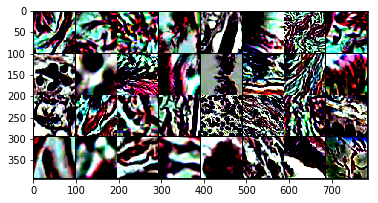

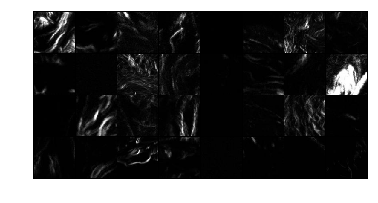

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


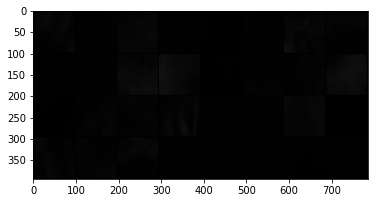

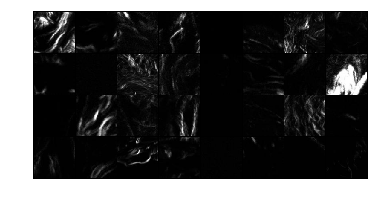

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


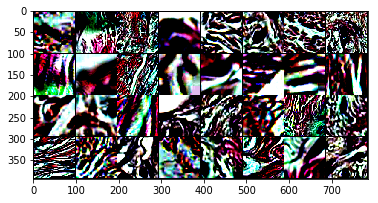

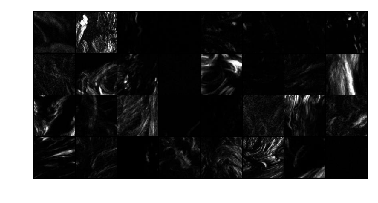

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


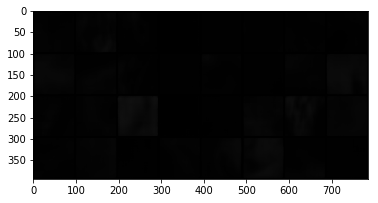

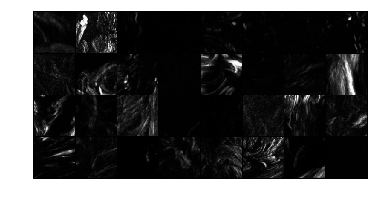

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


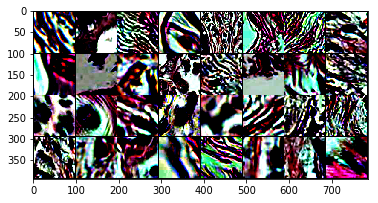

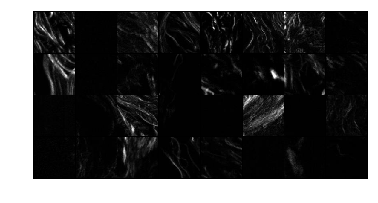

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


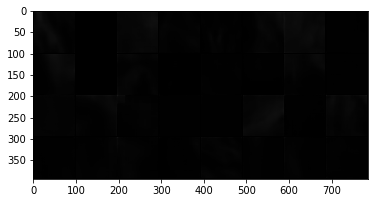

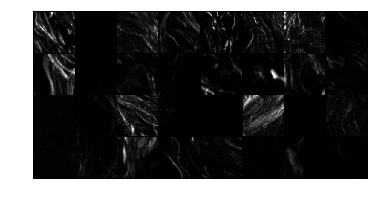

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


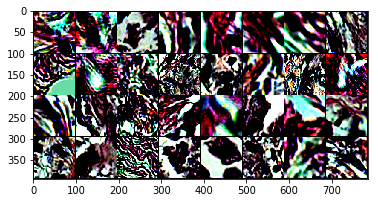

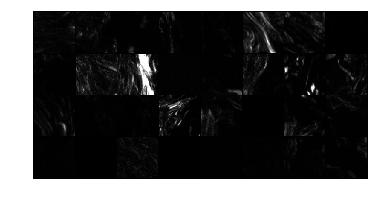

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


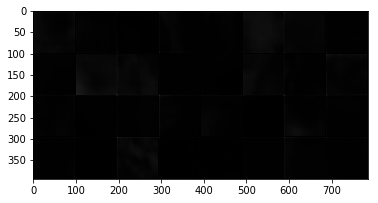

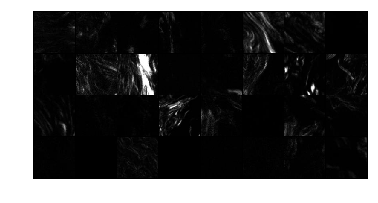

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


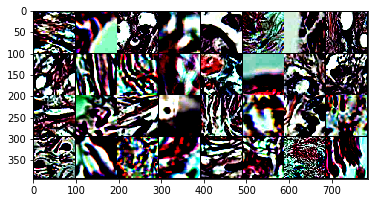

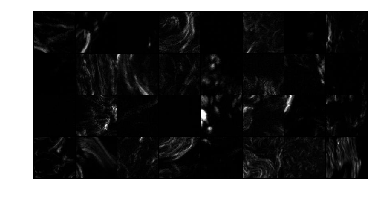

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


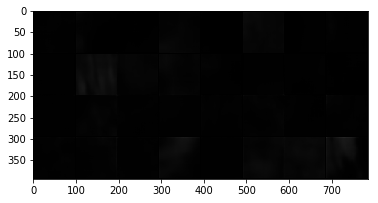

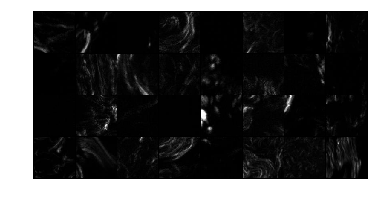

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


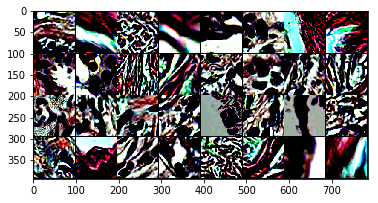

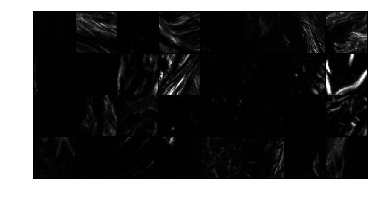

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


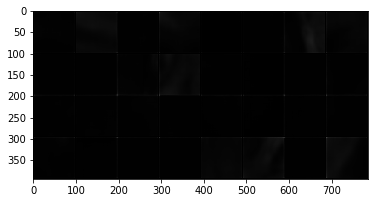

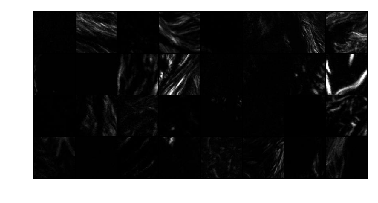

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


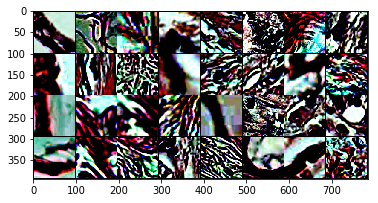

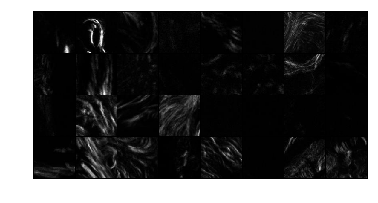

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


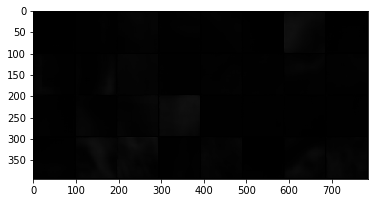

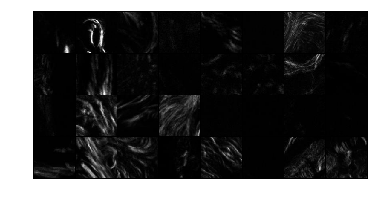

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


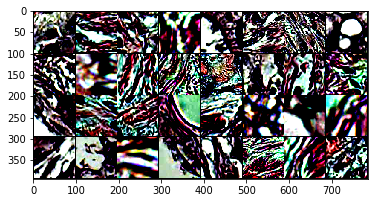

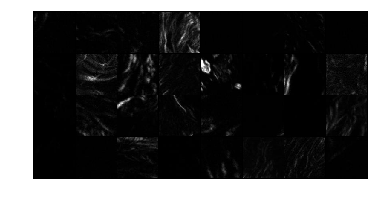

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


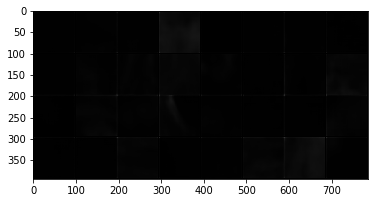

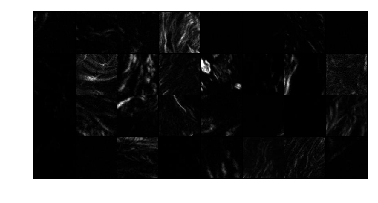

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


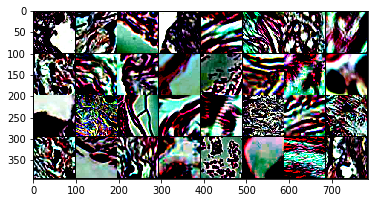

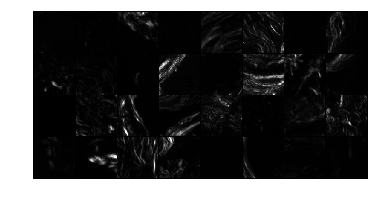

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


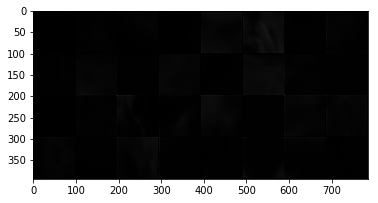

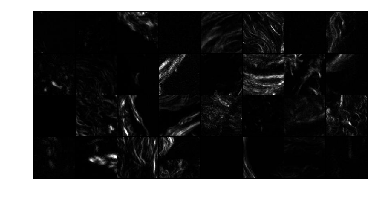

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


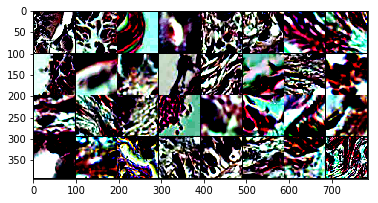

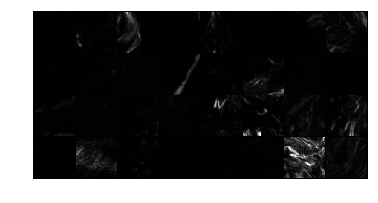

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


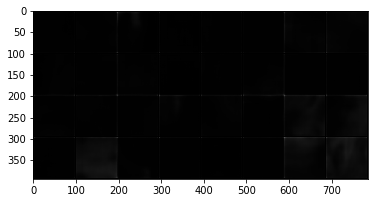

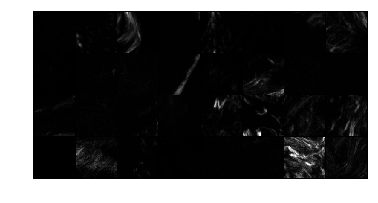

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


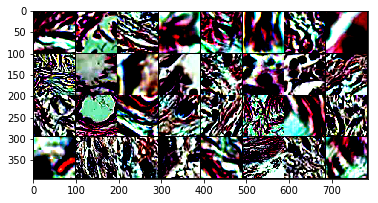

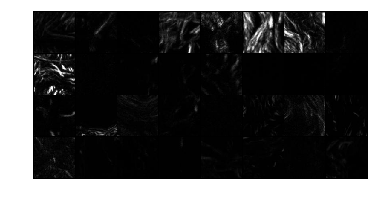

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


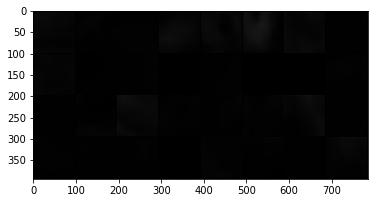

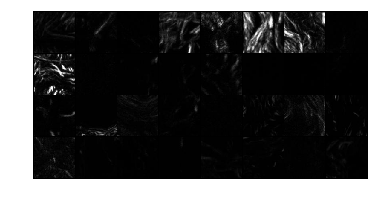

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


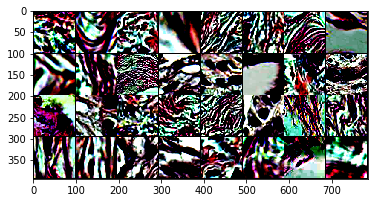

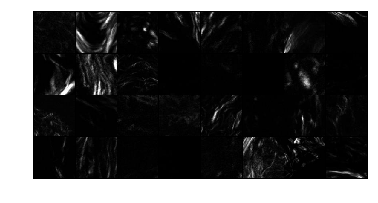

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


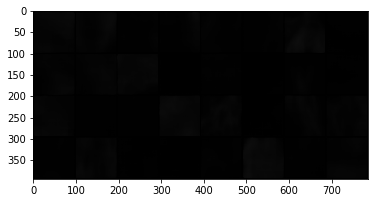

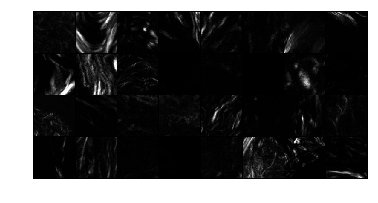

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


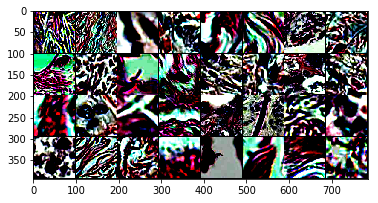

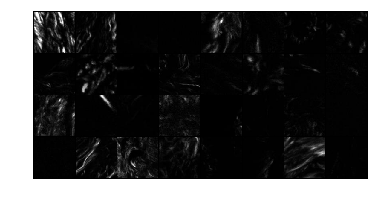

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


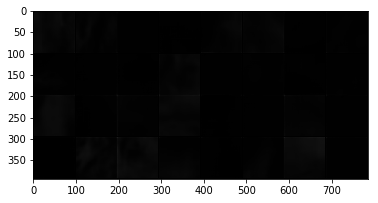

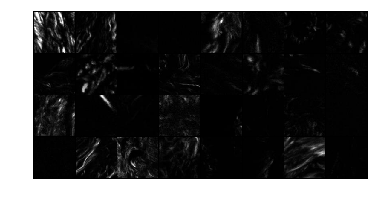

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


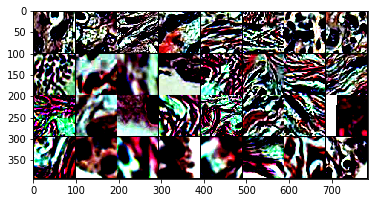

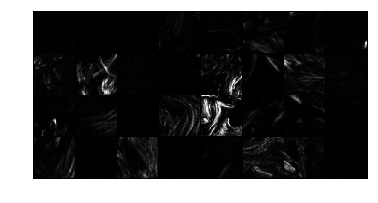

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


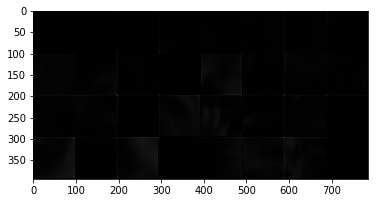

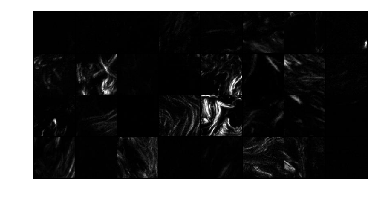

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


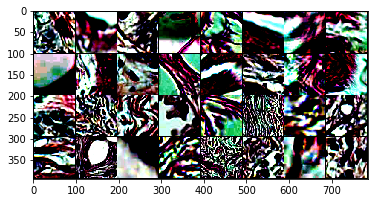

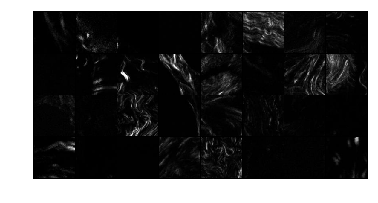

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


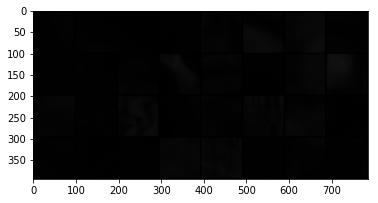

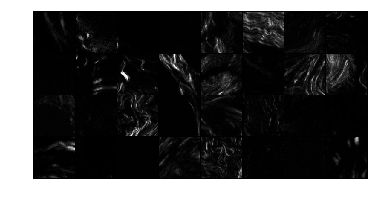

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


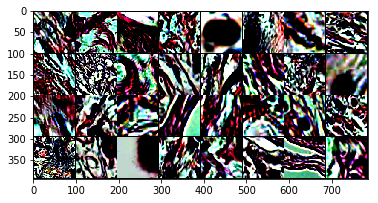

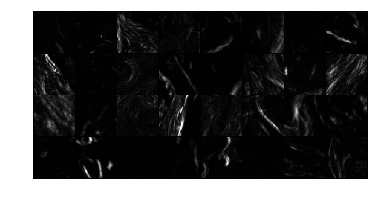

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


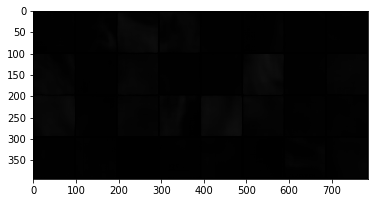

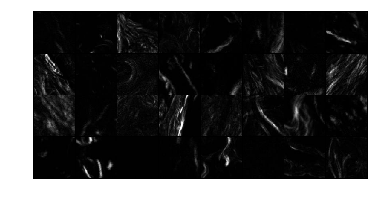

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 96, 96])


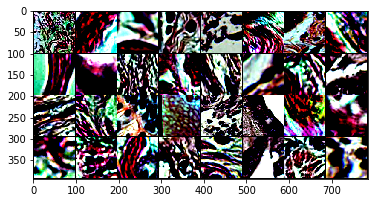

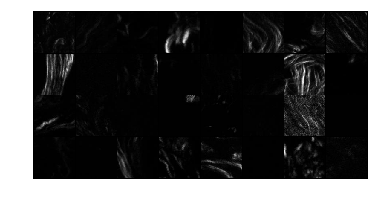

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


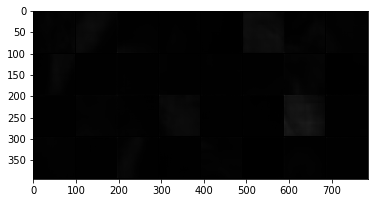

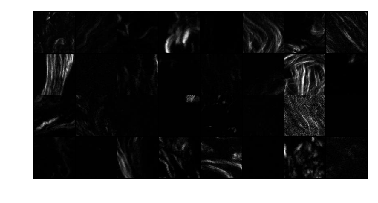

===> Avg. PSNR: nan dB


In [27]:
test()

In [ ]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

In [23]:
def tensormeanstd(img):
    mean = torch.tensor([0.0, 0.0, 0.0])
    std = torch.tensor([0.0, 0.0, 0.0])
    for i, channel in enumerate(img):
        mean[i] = torch.mean(img[i, :, :])
        std[i] = torch.std(img[i, :, :])
    return mean, std
            
def unnormalize_img(batch, mean, std):
    for img, imgmean, imgstd in zip(batch, mean, std):
        for t, m, s in zip(img, imgmean, imgstd):
            t.mul_(s).add_(m)
    return batch

def normalize_img(batch, mean, std):
    for img, imgmean, imgstd in zip(batch, mean, std):
        for t, m, s in zip(img, imgmean, imgstd):
            t.sub_(m).div_(s)
    return batch

def get_one_batch(dataloader):
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['input'].size(), 
              sample_batched['output'].size())
        if i_batch == 0:  
            break
    return sample_batched

def batch_mean_std(input_batch):
    batch_size = len(input_batch)
    batch_mean = torch.zeros([3, batch_size])
    batch_std = torch.zeros([3, batch_size])
    for i, img in enumerate(input_batch):
        batch_mean[:, i], batch_std[:, i] = tensormeanstd(img)    
    return batch_mean.permute(1, 0), batch_std.permute(1, 0)

def show_one_batch(sample, meanHE, stdHE, meanSHG, stdSHG):
    input_batch, label_batch = sample['input'], sample['output']
    batch_size = len(input_batch)
    im_size = input_batch.size(2)
    label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
    print(label_batch.size())
    
    input_batch = unnormalize_img(input_batch, meanHE, stdHE)
    stdSHG = torch.ones(3, batch_size)
#     label_batch = unnormalize_img(label_batch, meanSHG, stdSHG)
    
    grid = utils.make_grid(input_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.figure()

    grid = utils.make_grid(label_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
        
    plt.axis('off')
    plt.ioff()
    plt.show()   
    return

def normalizebatch(sample):
    input_batch, label_batch = sample['input'], sample['output']
    batch_size = len(input_batch)
    im_size = input_batch.size(2)
    label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
    print(label_batch.size())
    
    meanHE, stdHE = batch_mean_std(input_batch)
    meanSHG, stdSHG = batch_mean_std(label_batch)
    input_batch = normalize_img(input_batch, meanHE, stdHE)
    stdSHG = torch.ones(3, batch_size)
#     label_batch = normalize_img(label_batch, meanSHG, stdSHG)
    
    grid = utils.make_grid(input_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.figure()

    grid = utils.make_grid(label_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
        
    plt.axis('off')
    plt.ioff()
    plt.show() 
    sample['input'] = input_batch
    sample['output'] = label_batch
    
    return(sample, meanHE, stdHE, meanSHG, stdSHG)

In [28]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'Encoder6Info.pth')
torch.save(model.state_dict(), path)

In [ ]:
l = 0.0001
p = 0
windowsize = 6
for epoch in range(1, 20 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*0.5
        l = l*0.5
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.00299034733325243 lossSSIM: 0.23211431503295898
===> Epoch[1](0/25343): Loss: 0.2321
lossMSE: 0.00440229382365942 lossSSIM: 0.25043749809265137
===> Epoch[1](50/25343): Loss: 0.2504
lossMSE: 0.005821443162858486 lossSSIM: 0.2579387426376343
===> Epoch[1](100/25343): Loss: 0.2579
lossMSE: 0.007496833801269531 lossSSIM: 0.24402189254760742
===> Epoch[1](150/25343): Loss: 0.2440
lossMSE: 0.0036160098388791084 lossSSIM: 0.2563020586967468
===> Epoch[1](200/25343): Loss: 0.2563
lossMSE: 0.008457822725176811 lossSSIM: 0.30012357234954834
===> Epoch[1](250/25343): Loss: 0.3001
lossMSE: 0.005863610655069351 lossSSIM: 0.2587018609046936
===> Epoch[1](300/25343): Loss: 0.2587
lossMSE: 0.005455115344375372 lossSSIM: 0.24097460508346558
===> Epoch[1](350/25343): Loss: 0.2410
lossMSE: 0.0041509103029966354 lossSSIM: 0.23386603593826294
===> Epoch[1](400/25343): Loss: 0.2339
lossMSE: 0.009684554301202297 lossSSIM: 0.27526670694351196
===> Epoch[1](450/25343): Loss: 0.2753
lossMSE: 0.00432

lossMSE: 0.007329473737627268 lossSSIM: 0.3085941672325134
===> Epoch[1](4150/25343): Loss: 0.3086
lossMSE: 0.004552216734737158 lossSSIM: 0.2773529291152954
===> Epoch[1](4200/25343): Loss: 0.2774
lossMSE: 0.003976832609623671 lossSSIM: 0.2525228261947632
===> Epoch[1](4250/25343): Loss: 0.2525
lossMSE: 0.006279255263507366 lossSSIM: 0.2912482023239136
===> Epoch[1](4300/25343): Loss: 0.2912
lossMSE: 0.00693388981744647 lossSSIM: 0.294299840927124
===> Epoch[1](4350/25343): Loss: 0.2943
lossMSE: 0.005174763035029173 lossSSIM: 0.24035996198654175
===> Epoch[1](4400/25343): Loss: 0.2404
lossMSE: 0.006347278133034706 lossSSIM: 0.2710026502609253
===> Epoch[1](4450/25343): Loss: 0.2710
lossMSE: 0.01622670143842697 lossSSIM: 0.32660990953445435
===> Epoch[1](4500/25343): Loss: 0.3266
lossMSE: 0.008158531039953232 lossSSIM: 0.2833569049835205
===> Epoch[1](4550/25343): Loss: 0.2834
lossMSE: 0.002964387647807598 lossSSIM: 0.2173670530319214
===> Epoch[1](4600/25343): Loss: 0.2174
lossMSE: 0.

lossMSE: 0.0028687557205557823 lossSSIM: 0.23047399520874023
===> Epoch[1](8300/25343): Loss: 0.2305
lossMSE: 0.0055043939501047134 lossSSIM: 0.23522639274597168
===> Epoch[1](8350/25343): Loss: 0.2352
lossMSE: 0.006311292294412851 lossSSIM: 0.25490087270736694
===> Epoch[1](8400/25343): Loss: 0.2549
lossMSE: 0.0036292155273258686 lossSSIM: 0.2446010708808899
===> Epoch[1](8450/25343): Loss: 0.2446
lossMSE: 0.004376858472824097 lossSSIM: 0.25318121910095215
===> Epoch[1](8500/25343): Loss: 0.2532
lossMSE: 0.006939693354070187 lossSSIM: 0.275316059589386
===> Epoch[1](8550/25343): Loss: 0.2753
lossMSE: 0.00730193592607975 lossSSIM: 0.2657853960990906
===> Epoch[1](8600/25343): Loss: 0.2658
lossMSE: 0.013207841664552689 lossSSIM: 0.3118920922279358
===> Epoch[1](8650/25343): Loss: 0.3119
lossMSE: 0.026797374710440636 lossSSIM: 0.2660430669784546
===> Epoch[1](8700/25343): Loss: 0.2660
lossMSE: 0.0031103568617254496 lossSSIM: 0.21086329221725464
===> Epoch[1](8750/25343): Loss: 0.2109
los

lossMSE: 0.004773332737386227 lossSSIM: 0.23634392023086548
===> Epoch[1](12400/25343): Loss: 0.2363
lossMSE: 0.0033782466780394316 lossSSIM: 0.2549562454223633
===> Epoch[1](12450/25343): Loss: 0.2550
lossMSE: 0.004153173882514238 lossSSIM: 0.2386147379875183
===> Epoch[1](12500/25343): Loss: 0.2386
lossMSE: 0.005601017270237207 lossSSIM: 0.27467870712280273
===> Epoch[1](12550/25343): Loss: 0.2747
lossMSE: 0.009543330408632755 lossSSIM: 0.2765588164329529
===> Epoch[1](12600/25343): Loss: 0.2766
lossMSE: 0.008166060782968998 lossSSIM: 0.2695550322532654
===> Epoch[1](12650/25343): Loss: 0.2696
lossMSE: 0.00503389211371541 lossSSIM: 0.28674566745758057
===> Epoch[1](12700/25343): Loss: 0.2867
lossMSE: 0.014802996069192886 lossSSIM: 0.2922987937927246
===> Epoch[1](12750/25343): Loss: 0.2923
lossMSE: 0.0045241424813866615 lossSSIM: 0.2406870722770691
===> Epoch[1](12800/25343): Loss: 0.2407
lossMSE: 0.007401352282613516 lossSSIM: 0.24104911088943481
===> Epoch[1](12850/25343): Loss: 0.

lossMSE: 0.00546670937910676 lossSSIM: 0.274064302444458
===> Epoch[1](16500/25343): Loss: 0.2741
lossMSE: 0.007983965799212456 lossSSIM: 0.22242319583892822
===> Epoch[1](16550/25343): Loss: 0.2224
lossMSE: 0.0027513643726706505 lossSSIM: 0.22257918119430542
===> Epoch[1](16600/25343): Loss: 0.2226
lossMSE: 0.003022636752575636 lossSSIM: 0.22630083560943604
===> Epoch[1](16650/25343): Loss: 0.2263
lossMSE: 0.010576807893812656 lossSSIM: 0.30955713987350464
===> Epoch[1](16700/25343): Loss: 0.3096
lossMSE: 0.005444234237074852 lossSSIM: 0.2914111614227295
===> Epoch[1](16750/25343): Loss: 0.2914
lossMSE: 0.010035166516900063 lossSSIM: 0.29731547832489014
===> Epoch[1](16800/25343): Loss: 0.2973
lossMSE: 0.0022732997313141823 lossSSIM: 0.2241927981376648
===> Epoch[1](16850/25343): Loss: 0.2242
lossMSE: 0.006732502952218056 lossSSIM: 0.32269251346588135
===> Epoch[1](16900/25343): Loss: 0.3227
lossMSE: 0.0030299315694719553 lossSSIM: 0.23742032051086426
===> Epoch[1](16950/25343): Loss:

lossMSE: 0.004914294462651014 lossSSIM: 0.21104717254638672
===> Epoch[1](20600/25343): Loss: 0.2110
lossMSE: 0.005647469777613878 lossSSIM: 0.25922268629074097
===> Epoch[1](20650/25343): Loss: 0.2592
lossMSE: 0.012447687797248363 lossSSIM: 0.33914387226104736
===> Epoch[1](20700/25343): Loss: 0.3391
lossMSE: 0.0031255697831511497 lossSSIM: 0.25579625368118286
===> Epoch[1](20750/25343): Loss: 0.2558
lossMSE: 0.0048780739307403564 lossSSIM: 0.2625786066055298
===> Epoch[1](20800/25343): Loss: 0.2626
lossMSE: 0.0024081766605377197 lossSSIM: 0.24371463060379028
===> Epoch[1](20850/25343): Loss: 0.2437
lossMSE: 0.009506476111710072 lossSSIM: 0.25264644622802734
===> Epoch[1](20900/25343): Loss: 0.2526
lossMSE: 0.009532954543828964 lossSSIM: 0.26379477977752686
===> Epoch[1](20950/25343): Loss: 0.2638
lossMSE: 0.006486213766038418 lossSSIM: 0.29852384328842163
===> Epoch[1](21000/25343): Loss: 0.2985
lossMSE: 0.0047495560720562935 lossSSIM: 0.26036161184310913
===> Epoch[1](21050/25343): 

lossMSE: 0.006662923842668533 lossSSIM: 0.27953189611434937
===> Epoch[1](24700/25343): Loss: 0.2795
lossMSE: 0.004001122899353504 lossSSIM: 0.24612486362457275
===> Epoch[1](24750/25343): Loss: 0.2461
lossMSE: 0.007989681325852871 lossSSIM: 0.31635791063308716
===> Epoch[1](24800/25343): Loss: 0.3164
lossMSE: 0.007317202165722847 lossSSIM: 0.20065361261367798
===> Epoch[1](24850/25343): Loss: 0.2007
lossMSE: 0.01503068022429943 lossSSIM: 0.26729321479797363
===> Epoch[1](24900/25343): Loss: 0.2673
lossMSE: 0.005740427412092686 lossSSIM: 0.27515631914138794
===> Epoch[1](24950/25343): Loss: 0.2752
lossMSE: 0.0036563617177307606 lossSSIM: 0.19828277826309204
===> Epoch[1](25000/25343): Loss: 0.1983
lossMSE: 0.00738486647605896 lossSSIM: 0.2940260171890259
===> Epoch[1](25050/25343): Loss: 0.2940
lossMSE: 0.002880878746509552 lossSSIM: 0.19020789861679077
===> Epoch[1](25100/25343): Loss: 0.1902
lossMSE: 0.0038750171661376953 lossSSIM: 0.25477665662765503
===> Epoch[1](25150/25343): Loss

lossMSE: 0.010416334494948387 lossSSIM: 0.27202481031417847
===> Epoch[2](3450/25343): Loss: 0.2720
lossMSE: 0.005404059775173664 lossSSIM: 0.26162832975387573
===> Epoch[2](3500/25343): Loss: 0.2616
lossMSE: 0.00398760661482811 lossSSIM: 0.2381872534751892
===> Epoch[2](3550/25343): Loss: 0.2382
lossMSE: 0.004546209704130888 lossSSIM: 0.22443801164627075
===> Epoch[2](3600/25343): Loss: 0.2244
lossMSE: 0.006206206977367401 lossSSIM: 0.26520681381225586
===> Epoch[2](3650/25343): Loss: 0.2652
lossMSE: 0.0051268599927425385 lossSSIM: 0.2733139991760254
===> Epoch[2](3700/25343): Loss: 0.2733
lossMSE: 0.005448443815112114 lossSSIM: 0.29023081064224243
===> Epoch[2](3750/25343): Loss: 0.2902
lossMSE: 0.00930083729326725 lossSSIM: 0.2822105884552002
===> Epoch[2](3800/25343): Loss: 0.2822
lossMSE: 0.003724152920767665 lossSSIM: 0.22037023305892944
===> Epoch[2](3850/25343): Loss: 0.2204
lossMSE: 0.009870748966932297 lossSSIM: 0.23543810844421387
===> Epoch[2](3900/25343): Loss: 0.2354
loss

lossMSE: 0.006209447979927063 lossSSIM: 0.22926539182662964
===> Epoch[2](7600/25343): Loss: 0.2293
lossMSE: 0.005951311439275742 lossSSIM: 0.213387131690979
===> Epoch[2](7650/25343): Loss: 0.2134
lossMSE: 0.019353508949279785 lossSSIM: 0.3299967646598816
===> Epoch[2](7700/25343): Loss: 0.3300
lossMSE: 0.008771900087594986 lossSSIM: 0.22999775409698486
===> Epoch[2](7750/25343): Loss: 0.2300
lossMSE: 0.0038602491840720177 lossSSIM: 0.21931427717208862
===> Epoch[2](7800/25343): Loss: 0.2193
lossMSE: 0.005441185086965561 lossSSIM: 0.23800808191299438
===> Epoch[2](7850/25343): Loss: 0.2380
lossMSE: 0.007843892090022564 lossSSIM: 0.2784414291381836
===> Epoch[2](7900/25343): Loss: 0.2784
lossMSE: 0.006042949855327606 lossSSIM: 0.3268200159072876
===> Epoch[2](7950/25343): Loss: 0.3268
lossMSE: 0.0044198185205459595 lossSSIM: 0.28849083185195923
===> Epoch[2](8000/25343): Loss: 0.2885
lossMSE: 0.010501009412109852 lossSSIM: 0.27588850259780884
===> Epoch[2](8050/25343): Loss: 0.2759
los

lossMSE: 0.004491427913308144 lossSSIM: 0.27103567123413086
===> Epoch[2](11700/25343): Loss: 0.2710
lossMSE: 0.003775686025619507 lossSSIM: 0.24830877780914307
===> Epoch[2](11750/25343): Loss: 0.2483
lossMSE: 0.014510665088891983 lossSSIM: 0.287389874458313
===> Epoch[2](11800/25343): Loss: 0.2874
lossMSE: 0.00911988876760006 lossSSIM: 0.23146992921829224
===> Epoch[2](11850/25343): Loss: 0.2315
lossMSE: 0.006449194625020027 lossSSIM: 0.2730005383491516
===> Epoch[2](11900/25343): Loss: 0.2730
lossMSE: 0.005042620003223419 lossSSIM: 0.2177959680557251
===> Epoch[2](11950/25343): Loss: 0.2178
lossMSE: 0.006211317144334316 lossSSIM: 0.2913248538970947
===> Epoch[2](12000/25343): Loss: 0.2913
lossMSE: 0.005103160161525011 lossSSIM: 0.2940640449523926
===> Epoch[2](12050/25343): Loss: 0.2941
lossMSE: 0.003942834213376045 lossSSIM: 0.2380462884902954
===> Epoch[2](12100/25343): Loss: 0.2380
lossMSE: 0.0034865736961364746 lossSSIM: 0.2292662262916565
===> Epoch[2](12150/25343): Loss: 0.229

lossMSE: 0.006616672966629267 lossSSIM: 0.264101505279541
===> Epoch[2](15800/25343): Loss: 0.2641
lossMSE: 0.003945377189666033 lossSSIM: 0.25670576095581055
===> Epoch[2](15850/25343): Loss: 0.2567
lossMSE: 0.0038315607234835625 lossSSIM: 0.190318763256073
===> Epoch[2](15900/25343): Loss: 0.1903
lossMSE: 0.005255468189716339 lossSSIM: 0.27579015493392944
===> Epoch[2](15950/25343): Loss: 0.2758
lossMSE: 0.006937976460903883 lossSSIM: 0.22967946529388428
===> Epoch[2](16000/25343): Loss: 0.2297
lossMSE: 0.01096800621598959 lossSSIM: 0.3293081521987915
===> Epoch[2](16050/25343): Loss: 0.3293
lossMSE: 0.010276575572788715 lossSSIM: 0.22456347942352295
===> Epoch[2](16100/25343): Loss: 0.2246
lossMSE: 0.007534495554864407 lossSSIM: 0.2993621230125427
===> Epoch[2](16150/25343): Loss: 0.2994
lossMSE: 0.005446597933769226 lossSSIM: 0.29277026653289795
===> Epoch[2](16200/25343): Loss: 0.2928
lossMSE: 0.009571108967065811 lossSSIM: 0.30187100172042847
===> Epoch[2](16250/25343): Loss: 0.3

lossMSE: 0.007817999459803104 lossSSIM: 0.24162131547927856
===> Epoch[2](19900/25343): Loss: 0.2416
lossMSE: 0.009263426065444946 lossSSIM: 0.23586761951446533
===> Epoch[2](19950/25343): Loss: 0.2359
lossMSE: 0.003105335868895054 lossSSIM: 0.25854378938674927
===> Epoch[2](20000/25343): Loss: 0.2585
lossMSE: 0.0032292839605361223 lossSSIM: 0.21841073036193848
===> Epoch[2](20050/25343): Loss: 0.2184
lossMSE: 0.007411370053887367 lossSSIM: 0.22867804765701294
===> Epoch[2](20100/25343): Loss: 0.2287
lossMSE: 0.012117094360291958 lossSSIM: 0.33993077278137207
===> Epoch[2](20150/25343): Loss: 0.3399
lossMSE: 0.006503918208181858 lossSSIM: 0.2652251720428467
===> Epoch[2](20200/25343): Loss: 0.2652
lossMSE: 0.005453787744045258 lossSSIM: 0.26924753189086914
===> Epoch[2](20250/25343): Loss: 0.2692
lossMSE: 0.00664156349375844 lossSSIM: 0.23771649599075317
===> Epoch[2](20300/25343): Loss: 0.2377
lossMSE: 0.009771393612027168 lossSSIM: 0.29212111234664917
===> Epoch[2](20350/25343): Loss

lossMSE: 0.005963006056845188 lossSSIM: 0.2740316390991211
===> Epoch[2](24000/25343): Loss: 0.2740
lossMSE: 0.0016517824260517955 lossSSIM: 0.22460699081420898
===> Epoch[2](24050/25343): Loss: 0.2246
lossMSE: 0.007029368542134762 lossSSIM: 0.2793111801147461
===> Epoch[2](24100/25343): Loss: 0.2793
lossMSE: 0.015770772472023964 lossSSIM: 0.42594385147094727
===> Epoch[2](24150/25343): Loss: 0.4259
lossMSE: 0.00954183004796505 lossSSIM: 0.30036860704421997
===> Epoch[2](24200/25343): Loss: 0.3004
lossMSE: 0.007116267923265696 lossSSIM: 0.2713395357131958
===> Epoch[2](24250/25343): Loss: 0.2713
lossMSE: 0.010874046944081783 lossSSIM: 0.28905826807022095
===> Epoch[2](24300/25343): Loss: 0.2891
lossMSE: 0.006735783535987139 lossSSIM: 0.2690715789794922
===> Epoch[2](24350/25343): Loss: 0.2691
lossMSE: 0.008614014834165573 lossSSIM: 0.30630308389663696
===> Epoch[2](24400/25343): Loss: 0.3063
lossMSE: 0.00561135821044445 lossSSIM: 0.23347026109695435
===> Epoch[2](24450/25343): Loss: 0.

lossMSE: 0.0038520146626979113 lossSSIM: 0.23573225736618042
===> Epoch[3](2750/25343): Loss: 0.2357
lossMSE: 0.004577416926622391 lossSSIM: 0.25359171628952026
===> Epoch[3](2800/25343): Loss: 0.2536
lossMSE: 0.005114200059324503 lossSSIM: 0.2417987585067749
===> Epoch[3](2850/25343): Loss: 0.2418
lossMSE: 0.00989467091858387 lossSSIM: 0.2809290289878845
===> Epoch[3](2900/25343): Loss: 0.2809
lossMSE: 0.004525978583842516 lossSSIM: 0.2614858150482178
===> Epoch[3](2950/25343): Loss: 0.2615
lossMSE: 0.005751529708504677 lossSSIM: 0.24348056316375732
===> Epoch[3](3000/25343): Loss: 0.2435
lossMSE: 0.012843881733715534 lossSSIM: 0.2708074450492859
===> Epoch[3](3050/25343): Loss: 0.2708
lossMSE: 0.00707595981657505 lossSSIM: 0.26801514625549316
===> Epoch[3](3100/25343): Loss: 0.2680
lossMSE: 0.005669854581356049 lossSSIM: 0.21511566638946533
===> Epoch[3](3150/25343): Loss: 0.2151
lossMSE: 0.00357056618668139 lossSSIM: 0.2303047776222229
===> Epoch[3](3200/25343): Loss: 0.2303
lossMSE

lossMSE: 0.010074641555547714 lossSSIM: 0.23417890071868896
===> Epoch[3](6900/25343): Loss: 0.2342
lossMSE: 0.0030589906964451075 lossSSIM: 0.17078781127929688
===> Epoch[3](6950/25343): Loss: 0.1708
lossMSE: 0.004195363726466894 lossSSIM: 0.23976457118988037
===> Epoch[3](7000/25343): Loss: 0.2398
lossMSE: 0.01075006928294897 lossSSIM: 0.26423436403274536
===> Epoch[3](7050/25343): Loss: 0.2642
lossMSE: 0.004165425896644592 lossSSIM: 0.2666775584220886
===> Epoch[3](7100/25343): Loss: 0.2667
lossMSE: 0.009663540869951248 lossSSIM: 0.3050779700279236
===> Epoch[3](7150/25343): Loss: 0.3051
lossMSE: 0.007429216522723436 lossSSIM: 0.25765812397003174
===> Epoch[3](7200/25343): Loss: 0.2577
lossMSE: 0.0028881211765110493 lossSSIM: 0.24559295177459717
===> Epoch[3](7250/25343): Loss: 0.2456
lossMSE: 0.0034534165170043707 lossSSIM: 0.2526014447212219
===> Epoch[3](7300/25343): Loss: 0.2526
lossMSE: 0.004310712218284607 lossSSIM: 0.24442803859710693
===> Epoch[3](7350/25343): Loss: 0.2444
l

lossMSE: 0.004575740545988083 lossSSIM: 0.2731112241744995
===> Epoch[3](11050/25343): Loss: 0.2731
lossMSE: 0.014665648341178894 lossSSIM: 0.3344727158546448
===> Epoch[3](11100/25343): Loss: 0.3345
lossMSE: 0.009584405459463596 lossSSIM: 0.3214724063873291
===> Epoch[3](11150/25343): Loss: 0.3215
lossMSE: 0.008751061744987965 lossSSIM: 0.3027867078781128
===> Epoch[3](11200/25343): Loss: 0.3028
lossMSE: 0.0035872673615813255 lossSSIM: 0.20751696825027466
===> Epoch[3](11250/25343): Loss: 0.2075
lossMSE: 0.0029869023710489273 lossSSIM: 0.26005762815475464
===> Epoch[3](11300/25343): Loss: 0.2601
lossMSE: 0.003959686495363712 lossSSIM: 0.268559992313385
===> Epoch[3](11350/25343): Loss: 0.2686
lossMSE: 0.007475554943084717 lossSSIM: 0.2518109083175659
===> Epoch[3](11400/25343): Loss: 0.2518
lossMSE: 0.0044019510969519615 lossSSIM: 0.2316218614578247
===> Epoch[3](11450/25343): Loss: 0.2316
lossMSE: 0.006732631009072065 lossSSIM: 0.27909380197525024
===> Epoch[3](11500/25343): Loss: 0.

lossMSE: 0.005278799217194319 lossSSIM: 0.26183784008026123
===> Epoch[3](15150/25343): Loss: 0.2618
lossMSE: 0.0027274589519947767 lossSSIM: 0.2565274238586426
===> Epoch[3](15200/25343): Loss: 0.2565
lossMSE: 0.006191613152623177 lossSSIM: 0.23034942150115967
===> Epoch[3](15250/25343): Loss: 0.2303
lossMSE: 0.002953477203845978 lossSSIM: 0.24450916051864624
===> Epoch[3](15300/25343): Loss: 0.2445
lossMSE: 0.011204090900719166 lossSSIM: 0.3164079189300537
===> Epoch[3](15350/25343): Loss: 0.3164
lossMSE: 0.008824095129966736 lossSSIM: 0.22018957138061523
===> Epoch[3](15400/25343): Loss: 0.2202
lossMSE: 0.008777309209108353 lossSSIM: 0.32248014211654663
===> Epoch[3](15450/25343): Loss: 0.3225
lossMSE: 0.0060597569681704044 lossSSIM: 0.2577328085899353
===> Epoch[3](15500/25343): Loss: 0.2577
lossMSE: 0.006364268716424704 lossSSIM: 0.3069937229156494
===> Epoch[3](15550/25343): Loss: 0.3070
lossMSE: 0.005785216111689806 lossSSIM: 0.2167757749557495
===> Epoch[3](15600/25343): Loss: 

lossMSE: 0.0035990343894809484 lossSSIM: 0.20979207754135132
===> Epoch[3](19250/25343): Loss: 0.2098
lossMSE: 0.0036721527576446533 lossSSIM: 0.23610365390777588
===> Epoch[3](19300/25343): Loss: 0.2361
lossMSE: 0.004563771188259125 lossSSIM: 0.23436349630355835
===> Epoch[3](19350/25343): Loss: 0.2344
lossMSE: 0.0030954310204833746 lossSSIM: 0.23010998964309692
===> Epoch[3](19400/25343): Loss: 0.2301
lossMSE: 0.006498067639768124 lossSSIM: 0.27395331859588623
===> Epoch[3](19450/25343): Loss: 0.2740
lossMSE: 0.005976026877760887 lossSSIM: 0.2661281228065491
===> Epoch[3](19500/25343): Loss: 0.2661
lossMSE: 0.0077172014862298965 lossSSIM: 0.3129501938819885
===> Epoch[3](19550/25343): Loss: 0.3130
lossMSE: 0.0074632070027291775 lossSSIM: 0.30588412284851074
===> Epoch[3](19600/25343): Loss: 0.3059
lossMSE: 0.003683430142700672 lossSSIM: 0.22752630710601807
===> Epoch[3](19650/25343): Loss: 0.2275
lossMSE: 0.0036014989018440247 lossSSIM: 0.2256978154182434
===> Epoch[3](19700/25343): 

lossMSE: 0.004365833476185799 lossSSIM: 0.22651511430740356
===> Epoch[3](23350/25343): Loss: 0.2265
lossMSE: 0.007518392521888018 lossSSIM: 0.24949043989181519
===> Epoch[3](23400/25343): Loss: 0.2495
lossMSE: 0.005311311688274145 lossSSIM: 0.2590380311012268
===> Epoch[3](23450/25343): Loss: 0.2590
lossMSE: 0.005280231591314077 lossSSIM: 0.26380854845046997
===> Epoch[3](23500/25343): Loss: 0.2638
lossMSE: 0.003284393809735775 lossSSIM: 0.21358013153076172
===> Epoch[3](23550/25343): Loss: 0.2136
lossMSE: 0.006358398124575615 lossSSIM: 0.237443745136261
===> Epoch[3](23600/25343): Loss: 0.2374
lossMSE: 0.005640423856675625 lossSSIM: 0.24519503116607666
===> Epoch[3](23650/25343): Loss: 0.2452
lossMSE: 0.0032183935400098562 lossSSIM: 0.25619566440582275
===> Epoch[3](23700/25343): Loss: 0.2562
lossMSE: 0.010420877486467361 lossSSIM: 0.2547993063926697
===> Epoch[3](23750/25343): Loss: 0.2548
lossMSE: 0.005942460149526596 lossSSIM: 0.23677510023117065
===> Epoch[3](23800/25343): Loss: 

lossMSE: 0.0039242771454155445 lossSSIM: 0.18785744905471802
===> Epoch[4](2100/25343): Loss: 0.1879
lossMSE: 0.006197010632604361 lossSSIM: 0.2703458070755005
===> Epoch[4](2150/25343): Loss: 0.2703
lossMSE: 0.006310589145869017 lossSSIM: 0.2511284351348877
===> Epoch[4](2200/25343): Loss: 0.2511
lossMSE: 0.008209273219108582 lossSSIM: 0.3185613751411438
===> Epoch[4](2250/25343): Loss: 0.3186
lossMSE: 0.00861683115363121 lossSSIM: 0.2826841473579407
===> Epoch[4](2300/25343): Loss: 0.2827
lossMSE: 0.010189320892095566 lossSSIM: 0.3087812662124634
===> Epoch[4](2350/25343): Loss: 0.3088
lossMSE: 0.008238637819886208 lossSSIM: 0.3037431240081787
===> Epoch[4](2400/25343): Loss: 0.3037
lossMSE: 0.005013690330088139 lossSSIM: 0.27785295248031616
===> Epoch[4](2450/25343): Loss: 0.2779
lossMSE: 0.004432666581124067 lossSSIM: 0.2920025587081909
===> Epoch[4](2500/25343): Loss: 0.2920
lossMSE: 0.003405987983569503 lossSSIM: 0.21015894412994385
===> Epoch[4](2550/25343): Loss: 0.2102
lossMSE